# AGL Autoencoder

Based on https://github.com/bentrevett/pytorch-seq2seq/blob/master/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb


In [80]:
BASIS = "../"
MODELFOLDER = BASIS + "/models"
PLOTSFOLDER = BASIS + "/plots"
MODELAUTOSAVE = MODELFOLDER + "/autosave/"
PLOTSAUTOSAVE = PLOTSFOLDER + "/autosave/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/Colab_data/data.py .

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time
import copy
import itertools

import data

## Grammar

In [3]:
class GrammarGen():
    """
    Generates Grammar sequences from grammars, and offers other functionalities
    Grammars are dictionaries:
    - always have START
    - all paths lead eventually to END
    - Entries starting with the same letter
      have same output
    """

    def __init__(self, grammar=None):
        if grammar is None:
            self.grammar = data.g0()
        else:
            self.grammar = grammar

        # find how many letters in grammar
        self.len = len(set([token[0] for token in self.grammar if (token != 'START' and token != 'END')]))

        # variable to check how many sequences have been generated for the grammaticality test
        self.grammCheckMaxLen = -1

    def __len__(self):
        return self.len

    def generate(self, n):
        """Generates n tokens"""
        ret = []
        count = 0
        hashtrack = set()
        while count < n:
            token = []
            current = 'START'
            while current != 'END':
                # Append current
                if current != 'START':
                    token.append(current[0])
                # Choose next
                r = random.randint(0, len(self.grammar[current]) - 1)
                current = self.grammar[current][r]
            # Check if seq is already inside
            tokenhash = ''.join([str(x) for x in token])
            if tokenhash not in hashtrack:
                hashtrack.add(tokenhash)
                ret.append((token, ))
                count += 1

        return ret

    def generateAllGrammatical(self, maxlen=float('inf')):
        """Generates all grammatical sequences until length maxlen"""
        def genAllHelp(seq, current):
            if current == 'END':
                return [seq]
            if len(seq) >= maxlen:
                return []
            # Append Current
            if current != 'START':
                seq.append(current[0])
            # Generate next possibilities
            options = range(len(self.grammar[current]))
            ret = [(genAllHelp(copy.copy(seq), self.grammar[current][i]))
                   for i in options]
            return itertools.chain(*ret)
        return set([tuple(seq) for seq in genAllHelp([], 'START')])

    def isGrammatical(self, seqs):
        """Check for grammaticality of sequences in seqs"""
        maxlen = max([len(seq) for seq in seqs])
        if self.grammCheckMaxLen < maxlen:
            self.allGrammatical = self.generateAllGrammatical(maxlen)
            self.grammCheckMaxLen = maxlen

        return [tuple(seq) in self.allGrammatical for seq in seqs]

## Training



### Cosine Loss, Init_weights, count_parameters

In [4]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class CosineLoss():
    def __init__(self, vocabsize, ignore_index, reduction="mean"):
        self.vocabsize = vocabsize
        self.ignore_index = ignore_index
        self.eye = torch.eye(self.vocabsize).to(device)
        self.cosSim = nn.CosineSimilarity(dim=1)
        self.reduction = reduction

    def __call__(self, outputs, labels):
        maxlen = outputs.shape[0]
        bs = outputs.shape[1]

        # Deal with positions which should be ignored and make them the same as label
        if self.ignore_index is not None:
            ignore_positions = (labels == self.ignore_index).to(device)
            outputs[ignore_positions] = self.eye[self.ignore_index]

        # Convert labels to onehot
        labels_onehot = torch.empty((maxlen, bs, self.vocabsize)).to(device)
        for idx in range(maxlen):
            labels_onehot[idx,:,:] = self.eye[labels[idx,:]]

        # Put labels and output in correct form for torch cosSim function
        batch_first_labels = labels_onehot.permute(1,0,2)
        processed_labels = batch_first_labels.reshape(-1, maxlen * self.vocabsize)
        batch_first_outputs = outputs.permute(1,0,2)
        processed_outputs = batch_first_outputs.reshape(-1, maxlen * self.vocabsize)

        # use cosSim function
        res = (1 - self.cosSim(processed_labels, processed_outputs))

        # Same interface as native los functions: reductions for the output
        if self.reduction == "none":
            return res
        elif self.reduction == "mean":
            return res.mean()
        elif self.reduction == "sum":
            return res.sum()
        else:
            print("error")
            return None

### Train

In [5]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch
        trg = src
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        if isinstance(criterion, CosineLoss):
            loss = criterion(output, trg)
        else:
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            
            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]
            
            loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [6]:
def evaluate(model, dataloader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for seq, seq_len in dataloader:

            output = model(seq, seq_len, seq, 0) #turn off teacher forcing
            
            #seq = [seq_len, batch_size]
            #output = [seq_len, batch_size, output_dim]

            if isinstance(criterion, CosineLoss):
                loss = criterion(output, seq)
            else:
                output_dim = output.shape[-1]
                
                output = output[1:].view(-1, output_dim)
                trg = seq[1:].view(-1)
                
                #trg = [(trg len - 1) * batch size]
                #output = [(trg len - 1) * batch size, output dim]
                
                loss = criterion(output, trg)

            epoch_loss += loss.item()
            
    return epoch_loss / len(dataloader)

In [7]:
def evaluate_extra(model, dataloader, loss_func):

    model.eval()

    loss_total = 0

    with torch.no_grad():
        
        for seqs, seqs_len in dataloader:

            outputs = model(seqs, seqs_len, seqs, 0)

            loss = loss_func(outputs, seqs) / seqs.shape[1]

            loss_total += loss.item()
        
#        if loss_func == allOrNoneLoss:
#            return loss_total

        return loss_total / len(dataloader)

def cutEndToken(seq):
    ret = []
    for stim in seq:
        if stim == END_TOKEN:
            break
        ret.append(stim)
    return ret


def allOrNoneLoss(output, trg):
    bs = output.shape[1]
    ret = 0
    pred = output.argmax(-1)[1:]
    trg = trg[1:]
    for b in range(bs):
        p = cutEndToken(pred[:,b].tolist())
        t = cutEndToken(trg[:,b].tolist())
        ret += not p == t
    return torch.tensor(ret)

In [8]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

During Training in addition to collecting the train/validation loss, collect the amount of entirely correct predicted sequences on the train and test gr/ugr set.

In [9]:
def fit(model, task_id, epochs, step_size_evaluation, clip ):
    best_valid_loss = float('inf')

    total_hits = torch.zeros((N_TASKS + 1, 3, epochs//step_size_evaluation,))
    total_loss = torch.zeros((N_TASKS + 1, 3, epochs//step_size_evaluation,))
    # [:,0,:] = train, [:,1,:] = test, [:,2,:] = test_ugr
    # [task_id, dataset, evaluations]

    for epoch in range(epochs):
        
        start_time = time.time()
        
        train_loss = train(model, train_dls[task_id], optimizer, criterion, clip)
        valid_loss = evaluate(model, valid_dls[task_id], criterion)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), SAVENAME)

        if epoch % STEP_SIZE_EVALUATION == 0:
            idx = epoch//STEP_SIZE_EVALUATION
            for other_id in range(task_id + 1):
                total_loss[other_id,0,idx] = evaluate(model, train_dls[other_id], criterion)
                total_loss[other_id,1,idx] = evaluate(model, test_dls[other_id], criterion)
                total_loss[other_id,2,idx] = evaluate(model, test_ugr_dls[other_id], criterion)
                total_hits[other_id,0,idx] = evaluate_extra(model, train_dls[other_id], allOrNoneLoss)
                total_hits[other_id,1,idx] = evaluate_extra(model, test_dls[other_id], allOrNoneLoss)
                total_hits[other_id,2,idx] = evaluate_extra(model, test_ugr_dls[other_id], allOrNoneLoss)

        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
    return total_loss, total_hits

## Model

### Encoder

In [10]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
                
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

In [11]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

### Decoder

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [12]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference. 

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the `forward` method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each time-step is stored in the `attentions` 

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

## Data

First, get the training and test sequences.

### Sequencedataset
Define a Dataset for Sequences:
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [14]:
class SequenceDataset(Dataset):
    """
    Dataset for Sequences
    """

    def __init__(self, seqs):
        """
        Args:
            size (int): amount of sequences generated
        """
        self.seqs = seqs

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        return self.seqs[idx]

### collate_batch
Define collate_batch for the Dataloader: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

Sequences are padded and their non-padded lengths are returned.
Since pack_padded_sequences requires sequences to be sorted, they are sorted too.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    seq_lens = []
    processed_seqs = []
    # Sort in descending order
    batch.sort(reverse=True, key=(lambda x: len(x)))
    # append start and end token
    for seq in batch:
        seq = [START_TOKEN] + seq + [END_TOKEN]
        seq_lens.append(len(seq))
        processed_seqs.append(torch.tensor(seq))
    # pad
    padded_seqs = pad_sequence(processed_seqs)
    seq_lens = torch.tensor(seq_lens)
    return padded_seqs.to(device), seq_lens.to(device)

### Data parameters

In [34]:
N_TASKS = 2
BATCH_SIZE = 1

PAD_TOKEN = 0
START_TOKEN = 1
END_TOKEN = 2

### Task loading
For reproducability

In [35]:
SEED = 54321

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Load data

In [36]:
train_seqs = data.g0_train()
valid_seqs = data.g0_train()
test_seqs = data.g0_test_gr()
test_ugr_seqs = data.g0_test_ugr()

Sort for better perfomance

In [37]:
train_seqs.sort(key=(lambda x: len(x)))
valid_seqs.sort(key=(lambda x: len(x)))
test_seqs.sort(key=(lambda x: len(x)))
test_ugr_seqs.sort(key=(lambda x: len(x)))

In [38]:
def buildVocab(letterset):
    vocab = {'<pad>': PAD_TOKEN, '<sos>': START_TOKEN, '<eos>': END_TOKEN}
    counter = len(vocab)
    for letter in letterset:
        vocab[letter] = counter
        counter +=1
    return vocab

In [39]:
letters = set()
for seq in train_seqs:
    [letters.add(letter) for letter in seq]
letters = list(letters)

Make all tasks, creates an additional task with all sequences from all tasks mashed together

In [40]:
train_dls = []
valid_dls = []
test_dls = []
test_ugr_dls = []
vocabs = []
rvocabs = []
let2idxs = []
idx2lets = []

usedpermutations = set()
train_convs = []
valid_convs = []
test_convs = []
test_ugr_convs = []
for t in range(N_TASKS + 1):
    # Create normal tasks
    if t != N_TASKS:
        temp_letters = copy.copy(letters)

        while str(temp_letters) in usedpermutations:
            random.shuffle(temp_letters)
 
        usedpermutations.add(str(temp_letters))

        # Vocab
        vocabs.append(buildVocab(temp_letters))
        rvocabs.append({v: k for k, v in vocabs[-1].items()})

        # Conversion Functions
        let2idxs.append(lambda seq: [vocabs[-1][let] for let in seq])
        idx2lets.append(lambda seq: [rvocabs[-1][let] for let in seq])

        # Convert to indices
        train_conv = [let2idxs[-1](seq) for seq in train_seqs]
        valid_conv = [let2idxs[-1](seq) for seq in valid_seqs]
        test_conv = [let2idxs[-1](seq) for seq in test_seqs]
        test_ugr_conv = [let2idxs[-1](seq) for seq in test_ugr_seqs]

        # Add conv seq to sequence collection
        train_convs.extend(train_conv)
        valid_convs.extend(valid_conv)
        test_convs.extend(test_conv)
        test_ugr_convs.extend(test_ugr_conv)

    # Create joint task
    else:
        train_conv = train_convs
        valid_conv = valid_convs
        test_conv = test_convs
        test_ugr_conv = test_ugr_convs

    # Datasets
    train_ds = SequenceDataset(train_conv)
    valid_ds = SequenceDataset(valid_conv)
    test_ds = SequenceDataset(test_conv)
    test_ugr_ds = SequenceDataset(test_ugr_conv)
    
    # Dataloader
    train_dls.append(
        DataLoader(train_ds, batch_size=BATCH_SIZE,
                   shuffle=True, collate_fn=collate_batch))
    valid_dls.append(
        DataLoader(valid_ds, batch_size=BATCH_SIZE,
                   shuffle=False, collate_fn=collate_batch))
    test_dls.append(
        DataLoader(test_ds, batch_size=BATCH_SIZE,
                   shuffle=False, collate_fn=collate_batch))
    test_ugr_dls.append(
        DataLoader(test_ugr_ds, batch_size=BATCH_SIZE,
                   shuffle=False, collate_fn=collate_batch))

### Task loading v2

In [41]:
SWAP1 = 2
SWAP2 = 4
train_dls = []
valid_dls = []
test_dls = []
test_ugr_dls = []
vocabs = []
rvocabs = []
let2idx = lambda task_id, seq: [vocabs[task_id][let] for let in seq]
idx2let = lambda task_id, seq: [rvocabs[task_id][let] for let in seq]

usedpermutations = set()
listUsedPermutations = []
train_convs = []
valid_convs = []
test_convs = []
test_ugr_convs = []
alternate = 0
for t in range(N_TASKS + 1):
    # Create normal tasks
    if t != N_TASKS:
        if alternate == 0:
            temp_letters = copy.copy(letters)

            while str(temp_letters) in usedpermutations:
                random.shuffle(temp_letters)
    
            usedpermutations.add(str(temp_letters))
            listUsedPermutations.append(temp_letters)

            alternate = 1
        else:
            temp_letters = listUsedPermutations[-1]

            #Swap 5th and 6th indice
            temp_letters[SWAP1], temp_letters[SWAP2] = temp_letters[SWAP2], temp_letters[SWAP1]

            usedpermutations.add(str(temp_letters))

            alternate = 0

        # Vocab
        vocabs.append(buildVocab(temp_letters))
        rvocabs.append({v: k for k, v in vocabs[-1].items()})

        # Convert to indices
        train_conv = [let2idx(t, seq) for seq in train_seqs]
        valid_conv = [let2idx(t, seq) for seq in valid_seqs]
        test_conv = [let2idx(t, seq) for seq in test_seqs]
        test_ugr_conv = [let2idx(t, seq) for seq in test_ugr_seqs]

        # Add conv seq to sequence collection
        train_convs.extend(train_conv)
        valid_convs.extend(valid_conv)
        test_convs.extend(test_conv)
        test_ugr_convs.extend(test_ugr_conv)

    # Create joint task
    else:
        train_conv = train_convs
        valid_conv = valid_convs
        test_conv = test_convs
        test_ugr_conv = test_ugr_convs

    # Datasets
    train_ds = SequenceDataset(train_conv)
    valid_ds = SequenceDataset(valid_conv)
    test_ds = SequenceDataset(test_conv)
    test_ugr_ds = SequenceDataset(test_ugr_conv)
    
    # Dataloader
    train_dls.append(
        DataLoader(train_ds, batch_size=BATCH_SIZE,
                   shuffle=True, collate_fn=collate_batch))
    valid_dls.append(
        DataLoader(valid_ds, batch_size=BATCH_SIZE,
                   shuffle=False, collate_fn=collate_batch))
    test_dls.append(
        DataLoader(test_ds, batch_size=BATCH_SIZE,
                   shuffle=False, collate_fn=collate_batch))
    test_ugr_dls.append(
        DataLoader(test_ugr_ds, batch_size=BATCH_SIZE,
                   shuffle=False, collate_fn=collate_batch))

In [42]:
print(vocabs[0])
print(vocabs[1])
for i in range(len(valid_dls) - 1):
    for seqs, _ in valid_dls[i]:
        print(f"\nFirst Batch of Task {i}:")
        print(seqs)
        break

{'<pad>': 0, '<sos>': 1, '<eos>': 2, 'A': 3, 'D': 4, 'F': 5, 'G': 6, 'C': 7}
{'<pad>': 0, '<sos>': 1, '<eos>': 2, 'A': 3, 'D': 4, 'C': 5, 'G': 6, 'F': 7}

First Batch of Task 0:
tensor([[1],
        [3],
        [7],
        [5],
        [2]])

First Batch of Task 1:
tensor([[1],
        [3],
        [5],
        [7],
        [2]])


In [43]:
let2idx

<function __main__.<lambda>(task_id, seq)>

In [44]:
convTrainSeqs = lambda task_id: [let2idx(task_id, seq) for seq in train_seqs]
convTestSeqs = lambda task_id: [let2idx(task_id, seq) for seq in test_ugr_seqs]
tr1 = convTrainSeqs(0)
tr2 = convTrainSeqs(1)
te1 = convTestSeqs(0)
te2 = convTestSeqs(1)

for seq in tr1:
    if seq in tr2:
        print(se)
        print("hi")

for se in tr2:
    if se in te1:
        print(se)
        print("hi")


for i in range(len(tr1)):
    print(f"{tr1[i]} - {tr2[i]}")

[3, 7, 5] - [3, 5, 7]
[3, 7, 6, 5] - [3, 5, 6, 7]
[3, 4, 7, 5] - [3, 4, 5, 7]
[3, 7, 5, 7, 6] - [3, 5, 7, 5, 6]
[3, 4, 7, 5, 7] - [3, 4, 5, 7, 5]
[3, 7, 6, 5, 7, 6] - [3, 5, 6, 7, 5, 6]
[3, 4, 7, 5, 7, 6] - [3, 4, 5, 7, 5, 6]
[3, 4, 7, 6, 5, 7, 6] - [3, 4, 5, 6, 7, 5, 6]


## Parameters

In [54]:
INPUT_DIM = max(vocabs[0].values()) + 1
OUTPUT_DIM = max(vocabs[0].values()) + 1
ENC_EMB_DIM = 30
DEC_EMB_DIM = 30
ENC_HID_DIM = 10
DEC_HID_DIM = 10
ENC_DROPOUT = 0.7
DEC_DROPOUT = 0.7
LEARNING_RATE = 0.01
SRC_PAD_IDX = PAD_TOKEN
TRG_PAD_IDX = PAD_TOKEN
PREFIX = "tr"
N_EPOCHS = 200
CLIP = 1
STEP_SIZE_EVALUATION = 10
TEST_ALL_TASKS = 1  

## Plotting & Evaluation functions

### plotTranser, plotResults

In [46]:
def plotTransfer(data, title):
    # data = [n_methods, n_tasks, combinedepochs]
    n_methods, n_tasks, n_combinedepochs = data.shape
    fig, axs = plt.subplots(n_tasks, 1)
    colors = ['blue','green','orange','red','yellow','violett']
    
    xvals = range(0, n_combinedepochs * STEP_SIZE_EVALUATION, STEP_SIZE_EVALUATION)
    
    for task_idx in range(n_tasks):
        for method_idx in range(n_methods):
            axs[task_idx].plot(
                xvals,
                data[method_idx, task_idx],
                color=colors[method_idx]
            )
            axs[task_idx].set_ylim(0,1.1)
            if task_idx != n_tasks - 1:
                axs[task_idx].tick_params(
                    axis='x',
                    which='both',
                    labelbottom=False
                )
        x_lines = range(0, n_combinedepochs * STEP_SIZE_EVALUATION, N_EPOCHS)
        for xpos in x_lines:
            axs[task_idx].axvline(xpos, color="grey")
    fig.suptitle(title)
    fig.tight_layout()
    
def plotResults(hist_loss, hist_hits, plotLoss=False):
    if plotLoss:
        plotTransfer( hist_loss[:,0,:].unsqueeze(0), "Train Loss")
        plotTransfer( hist_loss[:,1,:].unsqueeze(0), "Test Gr Loss")
        plotTransfer( hist_loss[:,2,:].unsqueeze(0), "Test Ugr Loss")
    plotTransfer( hist_hits[:,0,:].unsqueeze(0), "Train Hits")
    plotTransfer( hist_hits[:,1,:].unsqueeze(0), "Test Gr Hits")
    plotTransfer( hist_hits[:,2,:].unsqueeze(0), "Test Ugr Hits")

### visual_eval

In [47]:
def visual_eval(model, test_dl):

    model.eval()
    
    errors = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(test_dl):

            src, src_len = batch
            trg = src

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            show_batch(output, trg)


def show_batch(output, trg):
    bs = output.shape[1]
    pred = output.argmax(-1)[1:]
    trg = trg[1:]
    for b in range(bs):
        p = cutEndToken(pred[:,b].tolist())
        t = cutEndToken(trg[:,b].tolist())
        status = "same" if p == t else "different"
        print(f"pred = {p} - {status} \ntrg  = {t}\n-")

### accuracy, accuracyAll

In [48]:
def accuracy(model):
    for task_id in range(N_TASKS + 1):
        gr_not_hits = evaluate_extra(model, test_dls[task_id], allOrNoneLoss)
        ugr_not_hits = evaluate_extra(model, test_ugr_dls[task_id], allOrNoneLoss)
        gr_hits = 1 - gr_not_hits
        ugr_hits = 1 - ugr_not_hits
        total_acc = (gr_hits + ugr_not_hits) / 2
        print(f"Task {task_id}: Acc {total_acc:2.2}% | Gr acc {gr_hits:2.2} | Ugr acc {ugr_not_hits:2.2}")
        
def accuracyAll(models):
    for model_id in range(len(models)):
        print(f"\nModel {model_id}")
        accuracy(models[model_id])

## Baseline A: Individual Training

### Experiment Individual Training

In [49]:
SEED = 54321
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [50]:
models_A = []
hist_losses_A = []
hist_hitsss_A = []
for n_task in range(N_TASKS + TEST_ALL_TASKS):
    SUFFIX = f"A{n_task}"
    title = f"{PREFIX}-AE-{ENC_EMB_DIM}-{ENC_HID_DIM}-{LEARNING_RATE}-{SUFFIX}"
    LOADNAME = MODELAUTOSAVE + title + ".pt"
    SAVENAME = MODELAUTOSAVE + title + ".pt"
    PLOTSAVE = PLOTSAUTOSAVE + title + ".png"

    attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
    model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

    optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
    criterion = CosineLoss(OUTPUT_DIM, ignore_index=TRG_PAD_IDX)
    
    print(title)
    print(model.apply(init_weights))
    print(f'The model has {count_parameters(model)} trainable parameters')
    
    hist_loss_temp, hist_hits_temp = fit(model, n_task, N_EPOCHS, STEP_SIZE_EVALUATION, CLIP)
    hist_losses_A.append(hist_loss_temp)
    hist_hitsss_A.append(hist_hits_temp)
    models_A.append(model)

tr-AE-30-10-0.01-A0
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8, 30)
    (rnn): GRU(30, 10, bidirectional=True)
    (fc): Linear(in_features=20, out_features=10, bias=True)
    (dropout): Dropout(p=0.7, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=30, out_features=10, bias=True)
      (v): Linear(in_features=10, out_features=1, bias=False)
    )
    (embedding): Embedding(8, 30)
    (rnn): GRU(50, 10)
    (fc_out): Linear(in_features=60, out_features=8, bias=True)
    (dropout): Dropout(p=0.7, inplace=False)
  )
)
The model has 5878 trainable parameters
Epoch: 01 | Time: 0m 0s
	Train Loss: 0.613 | Train PPL:   1.845
	 Val. Loss: 0.481 |  Val. PPL:   1.618
Epoch: 02 | Time: 0m 0s
	Train Loss: 0.472 | Train PPL:   1.603
	 Val. Loss: 0.435 |  Val. PPL:   1.545
Epoch: 03 | Time: 0m 0s
	Train Loss: 0.402 | Train PPL:   1.495
	 Val. Loss: 0.408 |  Val. PPL:   1.503
Epoch: 04 | Time: 0m 0s
	Train Loss: 0.377 | Train PPL:

Plot Results

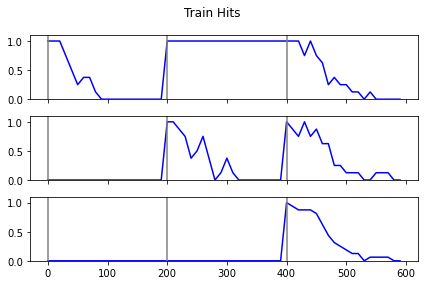

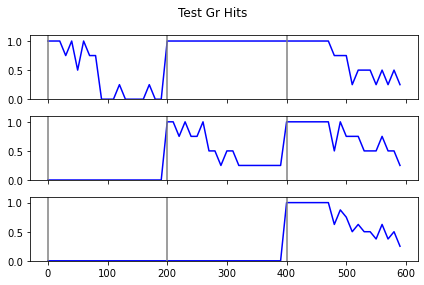

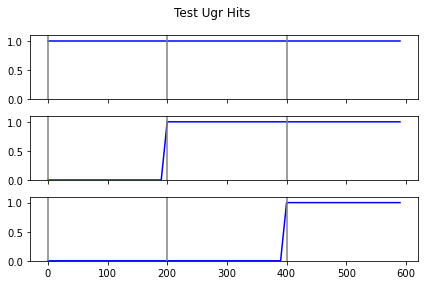

In [51]:
hist_loss_A = torch.cat(hist_losses_A, dim=2)
hist_hits_A = torch.cat(hist_hitsss_A, dim=2)

plotResults(hist_loss_A, hist_hits_A)

In numbers:

In [52]:
accuracyAll(models_A)


Model 0
Task 0: Acc 0.88% | Gr acc 0.75 | Ugr acc 1.0
Task 1: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 2: Acc 0.69% | Gr acc 0.38 | Ugr acc 1.0

Model 1
Task 0: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 1: Acc 0.88% | Gr acc 0.75 | Ugr acc 1.0
Task 2: Acc 0.69% | Gr acc 0.38 | Ugr acc 1.0

Model 2
Task 0: Acc 0.88% | Gr acc 0.75 | Ugr acc 1.0
Task 1: Acc 0.75% | Gr acc 0.5 | Ugr acc 1.0
Task 2: Acc 0.81% | Gr acc 0.62 | Ugr acc 1.0


## Baseline B: Keep Training same model

### Experiment Keep Training

In [55]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [56]:
models_B = []
hist_losses_B = []
hist_hitsss_B = []

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

print(model.apply(init_weights))

for n_task in range(N_TASKS + TEST_ALL_TASKS):
    SUFFIX = f"B{n_task}"
    title = f"{PREFIX}-AE-{ENC_EMB_DIM}-{ENC_HID_DIM}-{LEARNING_RATE}-{SUFFIX}"
    LOADNAME = MODELAUTOSAVE + title + ".pt"
    SAVENAME = MODELAUTOSAVE + title + ".pt"
    PLOTSAVE = PLOTSAUTOSAVE + title + ".png"
    
    optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
    criterion = CosineLoss(OUTPUT_DIM, ignore_index=TRG_PAD_IDX)
    
    print(title)
    print(f'The model has {count_parameters(model)} trainable parameters')
    
    hist_loss_temp, hist_hits_temp = fit(model, n_task, N_EPOCHS, STEP_SIZE_EVALUATION, CLIP)
    hist_losses_B.append(hist_loss_temp)
    hist_hitsss_B.append(hist_hits_temp)
    models_B.append(copy.deepcopy(model))

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8, 30)
    (rnn): GRU(30, 10, bidirectional=True)
    (fc): Linear(in_features=20, out_features=10, bias=True)
    (dropout): Dropout(p=0.7, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=30, out_features=10, bias=True)
      (v): Linear(in_features=10, out_features=1, bias=False)
    )
    (embedding): Embedding(8, 30)
    (rnn): GRU(50, 10)
    (fc_out): Linear(in_features=60, out_features=8, bias=True)
    (dropout): Dropout(p=0.7, inplace=False)
  )
)
tr-AE-30-10-0.01-B0
The model has 5878 trainable parameters
Epoch: 01 | Time: 0m 0s
	Train Loss: 0.613 | Train PPL:   1.845
	 Val. Loss: 0.481 |  Val. PPL:   1.618
Epoch: 02 | Time: 0m 0s
	Train Loss: 0.472 | Train PPL:   1.603
	 Val. Loss: 0.435 |  Val. PPL:   1.545
Epoch: 03 | Time: 0m 0s
	Train Loss: 0.402 | Train PPL:   1.495
	 Val. Loss: 0.408 |  Val. PPL:   1.503
Epoch: 04 | Time: 0m 0s
	Train Loss: 0.377 | Train PPL:

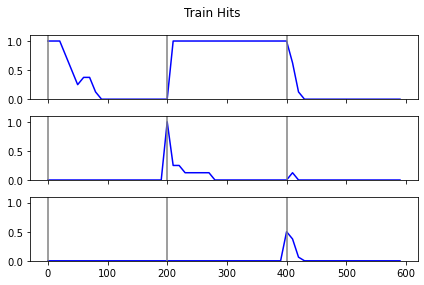

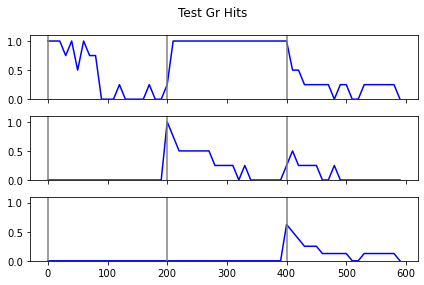

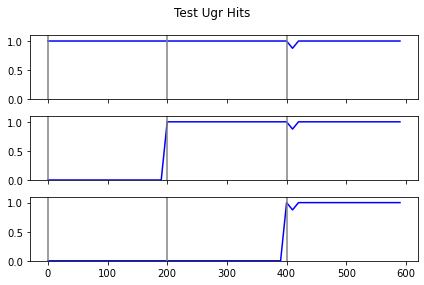

In [57]:
hist_loss_B = torch.cat(hist_losses_B, dim=2)
hist_hits_B = torch.cat(hist_hitsss_B, dim=2)

plotResults(hist_loss_B, hist_hits_B)

In numbers:

In [58]:
accuracyAll(models_B)


Model 0
Task 0: Acc 0.88% | Gr acc 0.75 | Ugr acc 1.0
Task 1: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 2: Acc 0.69% | Gr acc 0.38 | Ugr acc 1.0

Model 1
Task 0: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 1: Acc 1.0% | Gr acc 1.0 | Ugr acc 1.0
Task 2: Acc 0.75% | Gr acc 0.5 | Ugr acc 1.0

Model 2
Task 0: Acc 0.88% | Gr acc 0.75 | Ugr acc 1.0
Task 1: Acc 1.0% | Gr acc 1.0 | Ugr acc 1.0
Task 2: Acc 0.94% | Gr acc 0.88 | Ugr acc 1.0


## Baseline C: Freeze Parameters

1. Define functions
2. Train model, freeze core weights in between tasks
3. Look at performance

### onTaskUpdate, applyOnParameters, freezeParameters...

In [59]:
def applyOnParameters(model, conditions, apply_function):
    for name, param in model.named_parameters():
        # Check every condition
        for condition in conditions:
            # check every keyword
            allincluded = True
            for keyword in condition:
                if keyword not in name:
                    allincluded = False
                    break
            if allincluded:
                apply_function(param)

def freezeParameters(model, conditions):
    def freeze(param):
        param.requires_grad = False
    applyOnParameters(model, conditions, freeze)

def unfreezeParameters(model, conditions):
    def unfreeze(param):
        param.requires_grad = True
    applyOnParameters(model, conditions, unfreeze)

def showModelParameters(model, requires_grad=False):
    for name, param in model.named_parameters():
        if requires_grad:
            if param.requires_grad:
                print(name)
        else:
            print(name)
            
def onTaskUpdate(model):
    # Freeze core weights
    freezeParameters(model, ((""),))    # Freeze everything
    unfreezeParameters(model, (("encoder","embedding"), ("decoder","fc_out"), ("attention",))) # Unfreeze relevant stuff
    
    # Reinitialize
    to_constant = lambda param: nn.init.constant_(param.data, 0)
    applyOnParameters(model, (("decoder","fc_out","bias"),("attn","bias")), to_constant)
    to_normal = lambda param: nn.init.normal_(param.data, mean=0, std=0.01)
    applyOnParameters(model, (("encoder","embedding"),("decoder","fc_out","weight"),("attention","weight")), to_normal)

### Experiment Freeze Parameters

In [60]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [61]:
models_C = []
hist_losses_C = []
hist_hitsss_C = []

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

print(model.apply(init_weights))

for n_task in range(N_TASKS + TEST_ALL_TASKS):
    SUFFIX = f"C{n_task}"
    title = f"{PREFIX}-AE-{ENC_EMB_DIM}-{ENC_HID_DIM}-{LEARNING_RATE}-{SUFFIX}"
    LOADNAME = MODELAUTOSAVE + title + ".pt"
    SAVENAME = MODELAUTOSAVE + title + ".pt"
    PLOTSAVE = PLOTSAUTOSAVE + title + ".png"
    
    optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
    criterion = CosineLoss(OUTPUT_DIM, ignore_index=TRG_PAD_IDX)
    
    print(title)
    print(f'The model has {count_parameters(model)} trainable parameters')
    
    hist_loss_temp, hist_hits_temp = fit(model, n_task, N_EPOCHS, STEP_SIZE_EVALUATION, CLIP)
    hist_losses_C.append(hist_loss_temp)
    hist_hitsss_C.append(hist_hits_temp)
    models_C.append(copy.deepcopy(model))
    
    # Freeze, reinitialize
    onTaskUpdate(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8, 30)
    (rnn): GRU(30, 10, bidirectional=True)
    (fc): Linear(in_features=20, out_features=10, bias=True)
    (dropout): Dropout(p=0.7, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=30, out_features=10, bias=True)
      (v): Linear(in_features=10, out_features=1, bias=False)
    )
    (embedding): Embedding(8, 30)
    (rnn): GRU(50, 10)
    (fc_out): Linear(in_features=60, out_features=8, bias=True)
    (dropout): Dropout(p=0.7, inplace=False)
  )
)
tr-AE-30-10-0.01-C0
The model has 5878 trainable parameters
Epoch: 01 | Time: 0m 0s
	Train Loss: 0.613 | Train PPL:   1.845
	 Val. Loss: 0.481 |  Val. PPL:   1.618
Epoch: 02 | Time: 0m 0s
	Train Loss: 0.472 | Train PPL:   1.603
	 Val. Loss: 0.435 |  Val. PPL:   1.545
Epoch: 03 | Time: 0m 0s
	Train Loss: 0.402 | Train PPL:   1.495
	 Val. Loss: 0.408 |  Val. PPL:   1.503
Epoch: 04 | Time: 0m 0s
	Train Loss: 0.377 | Train PPL:

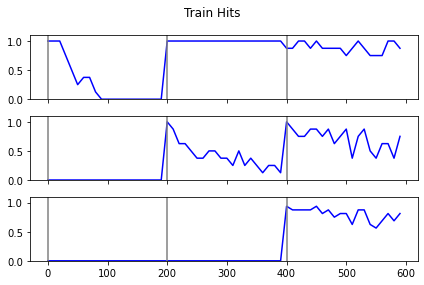

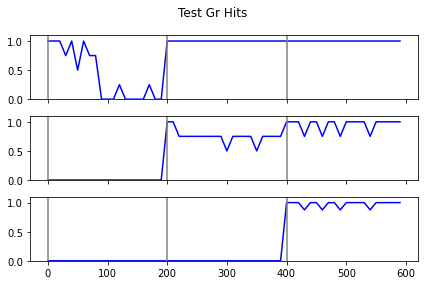

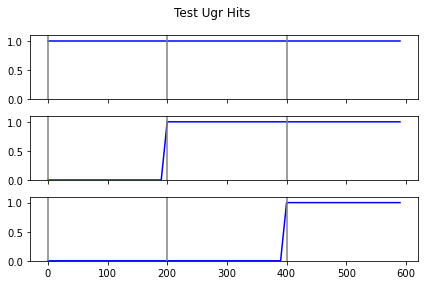

In [62]:
hist_loss_C = torch.cat(hist_losses_C, dim=2)
hist_hits_C = torch.cat(hist_hitsss_C, dim=2)

plotResults(hist_loss_C, hist_hits_C)

In [63]:
accuracyAll(models_C)


Model 0
Task 0: Acc 0.88% | Gr acc 0.75 | Ugr acc 1.0
Task 1: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 2: Acc 0.69% | Gr acc 0.38 | Ugr acc 1.0

Model 1
Task 0: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 1: Acc 0.75% | Gr acc 0.5 | Ugr acc 1.0
Task 2: Acc 0.62% | Gr acc 0.25 | Ugr acc 1.0

Model 2
Task 0: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 1: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 2: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0


## Transfer D: EWC

1. Create Fisher functions
2. Train model on tasks
3. Compare results

Based on: https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb

Compute optimal parameters and fisher information after training on tasks.

In [ ]:
def onTaskUpdate_ewc(model, task_id, train_dl, criterion):
    
    model.train()
    optimizer.zero_grad()
    
    #accumulate Gradient
    for it in range(100):
        for seq, seq_len in train_dl:

            optimizer.zero_grad()

            output = model(seq, seq_len, seq, 0)

            if criterion == F.cross_entropy:
              output_dim = output.shape[-1]
                
              output = output[1:].view(-1, output_dim)

              trg = seq[1:].view(-1)

              loss = criterion(output, trg)
            else:
              loss = criterion(output, seq)
            #print(loss)

            loss.backward()
        
    fishers.append({})
    optParams.append({})
    
    for name, param in model.named_parameters():
        fishers[task_id][name] = param.grad.data.clone().pow(2)
        optParams[task_id][name] = param.data.clone()

Adapt evaluation and training function.

In [ ]:
def train_ewc(model, task_id, dataloader, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for seq, seq_len in dataloader:
        
        optimizer.zero_grad()
        
        output = model(seq, seq_len, seq)
        loss = criterion(output, seq)
        
        if task_id > 0:
            print("-\n", loss)
        
        # EWC Training penalty
        for other_task_id in range(task_id):
            for name, param in model.named_parameters():
                fisher = fishers[other_task_id][name]
                optParam = optParams[other_task_id][name]
                #print(ewc_lambda)
                loss += (ewc_lambda / 2) * (fisher * (optParam - param).pow(2)).sum()
                #print((fisher * (optParam - param).pow(2)).sum())
                #print((optParam - param).pow(2).sum())
                #loss += ewc_lambda * (optParam - param).pow(2).sum()
        
        if task_id > 0:
            print(loss)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(dataloader)

In [ ]:
def evaluate_ewc(model, task_id, dataloader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():

        for seq, seq_len in dataloader:

            output = model(seq, seq_len, seq, 0) #turn off teacher forcing

            loss = criterion(output, seq).type(torch.float)
            
            # EWC Training penalty
            for other_task_id in range(task_id):
                for name, param in model.named_parameters():
                    fisher = fishers[other_task_id][name]
                    optParam = optParams[other_task_id][name]
                    loss += (ewc_lambda / 2) * (fisher * (optParam - param).pow(2)).sum()
                    
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [ ]:
def fit_ewc(model, task_id, epochs, step_size_evaluation, clip ):
    best_valid_loss = float('inf')

    total_hits = torch.zeros((N_TASKS + 1, 3, epochs//step_size_evaluation,))
    total_loss = torch.zeros((N_TASKS + 1, 3, epochs//step_size_evaluation,))
    # [:,0,:] = train, [:,1,:] = test, [:,2,:] = test_ugr
    # [task_id, dataset, evaluations]

    for epoch in range(epochs):
        
        start_time = time.time()
        
        train_loss = train_ewc(model, task_id, train_dls[task_id], optimizer, criterion, clip)
        valid_loss = evaluate_ewc(model, task_id, valid_dls[task_id], criterion)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), SAVENAME)

        if epoch % STEP_SIZE_EVALUATION == 0:
            idx = epoch//STEP_SIZE_EVALUATION
            for other_id in range(task_id + 1):
                total_loss[other_id,0,idx] = evaluate_ewc(model, task_id, train_dls[other_id], criterion)
                total_loss[other_id,1,idx] = evaluate_ewc(model, task_id, test_dls[other_id], criterion)
                total_loss[other_id,2,idx] = evaluate_ewc(model, task_id, test_ugr_dls[other_id], criterion)
                total_hits[other_id,0,idx] = evaluate_extra(model, train_dls[other_id], allOrNoneLoss)
                total_hits[other_id,1,idx] = evaluate_extra(model, test_dls[other_id], allOrNoneLoss)
                total_hits[other_id,2,idx] = evaluate_extra(model, test_ugr_dls[other_id], allOrNoneLoss)

        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
    return total_loss, total_hits

In [ ]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
fishers = []
optParams = []
ewc_lambda = 10

models_D = []
hist_losses_D = []
hist_hitsss_D = []

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

print(model.apply(init_weights))

for task_id in range(N_TASKS + TEST_ALL_TASKS):
    SUFFIX = f"D{task_id}"
    title = f"{PREFIX}-AE-{ENC_EMB_DIM}-{ENC_HID_DIM}-{LEARNING_RATE}-{SUFFIX}"
    LOADNAME = MODELAUTOSAVE + title + ".pt"
    SAVENAME = MODELAUTOSAVE + title + ".pt"
    PLOTSAVE = PLOTSAUTOSAVE + title + ".png"
    
    optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
    criterion = CosineLoss(OUTPUT_DIM, ignore_index=TRG_PAD_IDX)
    
    hist_loss_temp, hist_hits_temp = fit_ewc(model, task_id, N_EPOCHS, STEP_SIZE_EVALUATION, CLIP)
    hist_losses_D.append(hist_loss_temp)
    hist_hitsss_D.append(hist_hits_temp)
    models_D.append(copy.deepcopy(model))
    onTaskUpdate_ewc(model, task_id, train_dls[task_id], F.cross_entropy)

Streaming output truncated to the last 5000 lines.
 tensor(0.0976, grad_fn=<MeanBackward0>)
tensor(0.1117, grad_fn=<AddBackward0>)
Epoch: 15 | Time: 0m 0s
	Train Loss: 0.154 | Train PPL:   1.166
	 Val. Loss: 0.118 |  Val. PPL:   1.125
-
 tensor(0.1121, grad_fn=<MeanBackward0>)
tensor(0.1263, grad_fn=<AddBackward0>)
-
 tensor(0.1110, grad_fn=<MeanBackward0>)
tensor(0.1253, grad_fn=<AddBackward0>)
-
 tensor(0.1112, grad_fn=<MeanBackward0>)
tensor(0.1254, grad_fn=<AddBackward0>)
-
 tensor(0.1282, grad_fn=<MeanBackward0>)
tensor(0.1422, grad_fn=<AddBackward0>)
-
 tensor(0.1015, grad_fn=<MeanBackward0>)
tensor(0.1154, grad_fn=<AddBackward0>)
-
 tensor(0.0998, grad_fn=<MeanBackward0>)
tensor(0.1137, grad_fn=<AddBackward0>)
-
 tensor(0.0900, grad_fn=<MeanBackward0>)
tensor(0.1038, grad_fn=<AddBackward0>)
-
 tensor(0.1036, grad_fn=<MeanBackward0>)
tensor(0.1173, grad_fn=<AddBackward0>)
Epoch: 16 | Time: 0m 0s
	Train Loss: 0.121 | Train PPL:   1.129
	 Val. Loss: 0.108 |  Val. PPL:   1.115
-
 te

In [ ]:
hist_loss_D = torch.cat(hist_losses_D, dim=2)
hist_hits_D = torch.cat(hist_hitsss_D, dim=2)

plotResults(hist_loss_D, hist_hits_D)

L2 Regularization

In [ ]:
hist_loss_D = torch.cat(hist_losses_D, dim=2)
hist_hits_D = torch.cat(hist_hitsss_D, dim=2)

plotResults(hist_loss_D, hist_hits_D)

In [ ]:
accuracyAll(models_D)

In [ ]:
torch.max(fishers[0]['encoder.embedding.weight'])

## Transfer D2: L2 Regularization

### onTaskUpdate_l2reg

In [ ]:
def onTaskUpdate_l2reg(model, task_id, train_dl, criterion):
    # Save optimal parameters for each task
    optParams.append({})
    
    for name, param in model.named_parameters():
        optParams[task_id][name] = param.data.clone()

### train_l2reg

In [ ]:
def train_l2reg(model, task_id, dataloader, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for seq, seq_len in dataloader:
        
        optimizer.zero_grad()
        
        output = model(seq, seq_len, seq)
        loss = criterion(output, seq)
        
        # L2 Training penalty
        for other_task_id in range(task_id):
            for name, param in model.named_parameters():
                optParam = optParams[other_task_id][name]
                loss += LAMBDA_L2REG * (optParam - param).pow(2).sum()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(dataloader)

### eval_l2reg

In [ ]:
def evaluate_l2reg(model, task_id, dataloader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():

        for seq, seq_len in dataloader:

            output = model(seq, seq_len, seq, 0) #turn off teacher forcing

            loss = criterion(output, seq).type(torch.float)
            
            # L2 Training penalty
            for other_task_id in range(task_id):
                for name, param in model.named_parameters():
                    optParam = optParams[other_task_id][name]
                    loss += LAMBDA_L2REG * (optParam - param).pow(2).sum()
                    
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

### fit_l2reg

In [ ]:
def fit_l2reg(model, task_id, epochs, step_size_evaluation, clip ):
    best_valid_loss = float('inf')

    total_hits = torch.zeros((N_TASKS + 1, 3, epochs//step_size_evaluation,))
    total_loss = torch.zeros((N_TASKS + 1, 3, epochs//step_size_evaluation,))
    # [:,0,:] = train, [:,1,:] = test, [:,2,:] = test_ugr
    # [task_id, dataset, evaluations]

    for epoch in range(epochs):
        
        start_time = time.time()
        
        train_loss = train_l2reg(model, task_id, train_dls[task_id], optimizer, criterion, clip)
        valid_loss = evaluate_l2reg(model, task_id, valid_dls[task_id], criterion)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), SAVENAME)

        if epoch % STEP_SIZE_EVALUATION == 0:
            idx = epoch//STEP_SIZE_EVALUATION
            for other_id in range(task_id + 1):
                total_loss[other_id,0,idx] = evaluate_l2reg(model, task_id, train_dls[other_id], criterion)
                total_loss[other_id,1,idx] = evaluate_l2reg(model, task_id, test_dls[other_id], criterion)
                total_loss[other_id,2,idx] = evaluate_l2reg(model, task_id, test_ugr_dls[other_id], criterion)
                total_hits[other_id,0,idx] = evaluate_extra(model, train_dls[other_id], allOrNoneLoss)
                total_hits[other_id,1,idx] = evaluate_extra(model, test_dls[other_id], allOrNoneLoss)
                total_hits[other_id,2,idx] = evaluate_extra(model, test_ugr_dls[other_id], allOrNoneLoss)

        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
    return total_loss, total_hits

### Experiment L2 Regularization

In [ ]:
LAMBDA_L2REG = 0.02

In [ ]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
optParams = []

models_D2 = []
hist_losses_D2 = []
hist_hitsss_D2 = []

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

print(model.apply(init_weights))

for task_id in range(N_TASKS + TEST_ALL_TASKS):
    SUFFIX = f"D2.{task_id}"
    title = f"{PREFIX}-AE-{ENC_EMB_DIM}-{ENC_HID_DIM}-{LEARNING_RATE}-{SUFFIX}"
    LOADNAME = MODELAUTOSAVE + title + ".pt"
    SAVENAME = MODELAUTOSAVE + title + ".pt"
    PLOTSAVE = PLOTSAUTOSAVE + title + ".png"
    
    optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
    criterion = CosineLoss(OUTPUT_DIM, ignore_index=TRG_PAD_IDX)
    
    hist_loss_temp, hist_hits_temp = fit_l2reg(model, task_id, N_EPOCHS, STEP_SIZE_EVALUATION, CLIP)
    hist_losses_D2.append(hist_loss_temp)
    hist_hitsss_D2.append(hist_hits_temp)
    models_D2.append(copy.deepcopy(model))
    onTaskUpdate_l2reg(model, task_id, train_dls[task_id], F.cross_entropy)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8, 30)
    (rnn): GRU(30, 10, bidirectional=True)
    (fc): Linear(in_features=20, out_features=10, bias=True)
    (dropout): Dropout(p=0.7, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=30, out_features=10, bias=True)
      (v): Linear(in_features=10, out_features=1, bias=False)
    )
    (embedding): Embedding(8, 30)
    (rnn): GRU(50, 10)
    (fc_out): Linear(in_features=60, out_features=8, bias=True)
    (dropout): Dropout(p=0.7, inplace=False)
  )
)
Epoch: 01 | Time: 0m 0s
	Train Loss: 0.585 | Train PPL:   1.796
	 Val. Loss: 0.494 |  Val. PPL:   1.639
Epoch: 02 | Time: 0m 0s
	Train Loss: 0.479 | Train PPL:   1.614
	 Val. Loss: 0.452 |  Val. PPL:   1.571
Epoch: 03 | Time: 0m 0s
	Train Loss: 0.446 | Train PPL:   1.561
	 Val. Loss: 0.410 |  Val. PPL:   1.507
Epoch: 04 | Time: 0m 0s
	Train Loss: 0.384 | Train PPL:   1.467
	 Val. Loss: 0.410 |  Val. PPL:   1.506
Epoch: 05 |

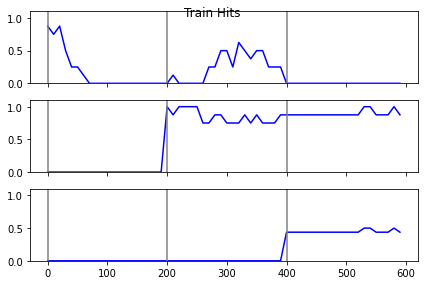

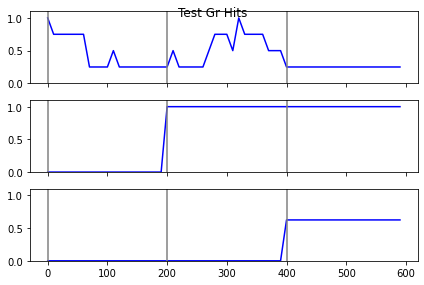

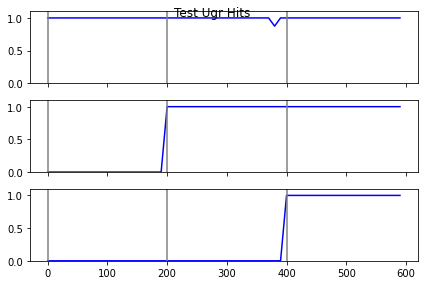

In [ ]:
hist_loss_D2 = torch.cat(hist_losses_D2, dim=2)
hist_hits_D2 = torch.cat(hist_hitsss_D2, dim=2)

plotResults(hist_loss_D2, hist_hits_D2)

In [ ]:
accuracyAll(models_D2)


Model 0
Task 0: Acc 0.88% | Gr acc 0.75 | Ugr acc 1.0
Task 1: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 2: Acc 0.69% | Gr acc 0.38 | Ugr acc 1.0

Model 1
Task 0: Acc 0.62% | Gr acc 0.25 | Ugr acc 1.0
Task 1: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 2: Acc 0.56% | Gr acc 0.12 | Ugr acc 1.0

Model 2
Task 0: Acc 0.88% | Gr acc 0.75 | Ugr acc 1.0
Task 1: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 2: Acc 0.69% | Gr acc 0.38 | Ugr acc 1.0


## Transfer E: DynaMoE

1. Create DynaMoe network functions:
2. Decider Network
3. Run experiment

Todos:
- Training by computing loss of every expert is cheaty?
- Training by feeding all new inputs to new expert is cheaty?
- Consolidating Network on task change is cheaty!


### Gating

In [64]:
class Gating(nn.Module):
    def __init__(self, input_dim, embed_dim, n_gating_hidden, n_experts,
                 n_max_experts, dropout):
        super().__init__()

        self.input_dim = input_dim
        
        self.n_experts = n_experts

        self.n_max_experts = n_max_experts
        
        self.embedding = nn.Embedding(input_dim, embed_dim)
        
        self.rnn = nn.GRU(embed_dim, n_gating_hidden, bidirectional=True)

        self.fc_out = nn.Linear(n_gating_hidden * 2, n_max_experts)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, seqs, seqs_len):
        
        # seqs = [seq len, batch_size]
        # seqs_len = [batch_size]
        
        embedded = self.dropout(self.embedding(seqs))
        
        # embedded = [seq len, batch_size, embed_dim]

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, seqs_len.to("cpu"))

        packed_outputs, hidden = self.rnn(packed_embedded)

        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)

        # outputs = [seq len, batch_size, n_experts * num directions]
        # hidden = [n layers * num directions, batch size, n_experts]

        hidden = hidden.squeeze(0)

        # hidden = [batch_size, n_max_experts]

        outputs = outputs[-1]

        outputs = self.fc_out(outputs)

        # outputs = [batch_size, n_max_experts]

        return outputs
        return F.softmax(outputs, dim=1)

### DynaMoE

In [65]:
class DynaMoE(nn.Module):
    def __init__(self, gating, gating_optimizer, experts, expert_optimizers):
        """
        Parameters
        ----------
        gating: nn.Module
            Gating module
        gating_optimizer: optim
            optimizer for passed Gating module
        expert: list of nn.Module
            list of task experts
        expert_optimizers: list of optim
            list of optimizer for the expert at the same index
        """
        super(DynaMoE, self).__init__()

        assert len(experts) == len(expert_optimizers)
        
        self.gating = gating
        self.gating_optimizer = gating_optimizer
        self.experts = nn.ModuleList(experts)
        self.expert_optimizers = expert_optimizers
        self.n_active_experts = 1
        # set mask
        self.recompute_mask()
    
    def recompute_mask(self):
        gating_mask = torch.zeros(self.gating.n_max_experts).to(device)

        for e_id in range(self.n_active_experts):
            gating_mask[e_id] = 1

        self.gating_mask = gating_mask

    def forward(self, seqs, seqs_len, trgs, teacher_forcing_ratio=0.5):
        #seqs = [seqs len, batch size]
        #seqs_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing

        vocab_size = self.gating.input_dim
        seq_len, batch_size = seqs.shape
        
        # Decide which expert to use
        gatings = self.gating(seqs, seqs_len)

        # gatings = [batch_size, n_max_experts]
        
        masked_gatings = gatings[:,:self.n_active_experts]
        
        # @TODO: Probabilistic vs argmax?
        network_ids = torch.argmax(masked_gatings, dim=1)

        expert_outputs = []
        for e_id in range(self.n_active_experts):
            expert_outputs.append(self.experts[e_id](seqs, seqs_len, seqs,
                                                     teacher_forcing_ratio))

        outputs = torch.empty((seq_len, batch_size, vocab_size))

        for b in range(batch_size):
            network_id = network_ids[b]
            outputs[:,b] = expert_outputs[network_id][:,b]
        
        return outputs

    def add_expert(self):
        # Get new expert
        expert, expert_optimizer = init_expert()
        self.experts.append(expert)
        self.expert_optimizers.append(expert_optimizer)
        self.n_active_experts += 1
        # Recompute mask
        self.recompute_mask()

### compute_loss

In [66]:
def compute_loss(outputs, targets, criterion, cutFirstInSequence=True):
    if isinstance(criterion, CosineLoss):
        return criterion(outputs, targets)
    else:
        outputs_dim = outputs.shape[-1]
        
        if cutFirstInSequence:
            outputs = outputs[1:].view(-1, outputs_dim)
            #outputs = [batch size, output dim]
            targets = targets[1:].view(-1)
            #targets = [batch size]
            # print("hi")
        else:
            outputs = outputs.view(-1, outputs_dim)
            targets = targets.view(-1)
        
        # print("######")
        # print(outputs)
        # print(targets)
        # print("######")
        
        return criterion(outputs, targets)

### train_dynamoe_gating

In [67]:
def train_dynamoe_gating(model, iterator, gating_criterion,
                         expert_criterion, clip, verbose=False):
    
    model.gating.train()
    
    epoch_loss = 0
    
    for seqs, seqs_len in iterator:
        
        #seqs = [seq len, batch size]
        #output = [seq len, batch size, vocab sizen]
        batch_size = seqs.shape[1]

        model.gating_optimizer.zero_grad()
        
        gating_outputs = model.gating(seqs, seqs_len)

        # gating_outputs = [batch_size, n_max_experts]

        ## Compute best choice for gating network
        # Compute loss for each expert network
        loss_experts = torch.empty((batch_size, model.n_active_experts))
        expert_trgs = seqs
        for e_id in range(model.n_active_experts):

            model.experts[e_id].eval()
            
            with torch.no_grad():

                # Get model prediction
                expert_outputs = model.experts[e_id](seqs, seqs_len, expert_trgs)

                loss = compute_loss(expert_outputs, expert_trgs,
                                    expert_criterion,
                                    cutFirstInSequence=True)
            
            # Log loss to train gating
            loss_experts[:,e_id] = loss

        # Indices of correct experts to have chosen
        gating_trgs = loss_experts.argmin(dim=1)
        # gating_trgs = [batch_size]

        if verbose:
            print("Target")
            print(gating_trgs)
            print("Output")
            print(gating_outputs.argmax(dim=1))

        gating_trgs = gating_trgs.unsqueeze(0)
        # gating_trgs = [[batch_size]]
        gating_outputs = gating_outputs.unsqueeze(0)
        # gating_ouputs = [[batch_size, n_max_experts]]

        gating_loss = compute_loss(gating_outputs, gating_trgs, gating_criterion,
                            cutFirstInSequence=False)
        
        if verbose:
            print(">> Gating Loss")
            print(gating_loss)

        gating_loss.backward()
        
        #torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        model.gating_optimizer.step()
        
        # Get loss of model gating chose
        gating_masked = gating_outputs.squeeze(0)[:,:model.n_active_experts]

        if verbose:
            print("-- Masked Gating")
            print(gating_masked)
        gating_choices = gating_masked.argmax(dim=1)
        # gating_choices = [batch_size]

        loss_chosen_experts = loss_experts[:,gating_choices]
        
        loss_chosen_experts = loss_chosen_experts.mean()
        
        epoch_loss += loss_chosen_experts.item()
        
    return epoch_loss / len(iterator)

### train_dynamoe_both

In [68]:
def train_dynamoe_both(model, iterator, gating_criterion,
                       expert_criterion, clip):

    model.gating.train()
    
    epoch_loss = 0
    
    for seqs, seqs_len in iterator:
        #seqs = [seq len, batch size]
        #output = [seq len, batch size, vocab sizen]

        batch_size = seqs.shape[1]

        model.gating_optimizer.zero_grad()
        
        gating_outputs = model.gating(seqs, seqs_len)
        # gating_outputs = [batch_size, n_max_experts]

        ## Compute best choice for gating network
        # Compute loss for each expert network
        loss_experts = torch.empty((batch_size, model.n_active_experts))
        # loss_experts = [batch_size, n_active_experts]
        expert_trgs = seqs
        for e_id in range(model.n_active_experts):

            train_model = e_id == model.n_active_experts - 1

            if train_model:
                model.experts[e_id].train()
                model.expert_optimizers[e_id].zero_grad()
                
                # Get model prediction
                expert_outputs = model.experts[e_id](seqs, seqs_len, expert_trgs)

                loss = compute_loss(expert_outputs, expert_trgs, expert_criterion,
                                    cutFirstInSequence=True)

                # Log loss to train gating
                loss_experts[:,e_id] = loss
                
                # Train newly initialized model on new train examples
                reduced_loss = loss.mean()
                reduced_loss.backward()
                model.expert_optimizers[e_id].step()
                
            else:
                model.experts[e_id].eval()
                
                with torch.no_grad():

                    # Get model prediction
                    expert_outputs = model.experts[e_id](seqs, seqs_len, expert_trgs)

                    loss = compute_loss(expert_outputs, expert_trgs, expert_criterion,
                                        cutFirstInSequence=True)

                    # Log loss to train gating
                    loss_experts[:,e_id] = loss

        # Compute expert which should have been chosen
        gating_trgs = loss_experts.argmin(dim=1)
        # gating_trgs = [batch_size]

        gating_trgs = gating_trgs.unsqueeze(0)
        # gating_trgs = [[batch_size]]
        gating_outputs = gating_outputs.unsqueeze(0)
        # gating_ouputs = [[batch_size, n_max_experts]]

        gating_loss = compute_loss(gating_outputs, gating_trgs, gating_criterion,
                            cutFirstInSequence=False)

        gating_loss.backward()
        
        #torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        model.gating_optimizer.step()

        # Get loss of model gating chose
        gating_masked = gating_outputs.squeeze(0)[:,:model.n_active_experts]
        gating_choices = gating_masked.argmax(dim=1)
        # gating_choices = [batch_size]

        loss_chosen_experts = loss_experts[:,gating_choices]
        
        loss_chosen_experts = loss_chosen_experts.mean()
        
        epoch_loss += loss_chosen_experts.item()
        
    return epoch_loss / len(iterator)

### Init

In [69]:
def init_expert():
    attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
    new_expert = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)
    new_expert.apply(init_weights)
    expert_optimizer = optim.Adam(new_expert.parameters(), lr=LEARNING_RATE)
    return new_expert, expert_optimizer

In [70]:
def init_gating():
    gating = Gating(INPUT_DIM, N_GATING_EMBED_DIM, N_GATING_HIDDEN_DIM,
                    N_EXPERTS_START, N_MAX_EXPERTS, GATE_DROPOUT)
    gating.to(device)
    gating_optimizer = optim.Adam(gating.parameters(), lr=LEARNING_RATE)
    return gating, gating_optimizer

### show expert

In [71]:
def show_expert(model, iterator):
    model.gating.eval()
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            seqs, seqs_len = batch

            batch_size = seqs.shape[1]

            gating_outputs = model.gating(seqs, seqs_len)

            gating_masked = gating_outputs[:,:model.n_active_experts]

            gating_choices = gating_masked.argmax(dim=1)

            for b in range(batch_size):
                print(f"{gating_choices[b]} - {seqs[:,b]}")            

### fit_dynamoe

In [72]:
def fit_dynamoe(model, task_id, epochs, step_size_evaluation, clip,
                case = "train_gating_initialized_expert" ):
    """
    Parameters
    ----------
    case : string
        "train_gating_uninitialized_expert" | "train_gating_train_expert" | 
        "train_gating_initialized_expert"
    """
    best_valid_loss = float('inf')

    total_hits = torch.zeros((N_TASKS + 1, 3, epochs//step_size_evaluation,))
    total_loss = torch.zeros((N_TASKS + 1, 3, epochs//step_size_evaluation,))
    # [:,0,:] = train, [:,1,:] = test, [:,2,:] = test_ugr
    # [task_id, dataset, evaluations]

    loss_tracker = torch.zeros((epochs,))

    allowed_until_check = N_EPOCHS_UNTIL_NEW_EXPERT

    for epoch in range(epochs):

        if case == "train_gating_initialized_expert":
            start_time = time.time()
            
            train_loss = train_dynamoe_gating(model, train_dls[task_id],
                                              gating_criterion,
                                              expert_criterion_unreduced, clip)
            valid_loss = evaluate(model, valid_dls[task_id], expert_criterion)
            
            end_time = time.time()

            # Log hits
            loss_tracker[epoch] = evaluate_extra(model, train_dls[task_id], allOrNoneLoss)

            # Check for improvement in loss
            if epoch > allowed_until_check:
                if (((loss_tracker[epoch - N_EPOCHS_UNTIL_NEW_EXPERT] - 
                         loss_tracker[epoch]) < ALLOWED_ERROR_VARIANCE)
                    and 
                    (valid_loss > PERFORMANCE_TRESHHOLD)
                ):
                    # Case of no improvement:
                    # Switch to train the expert and gating

                    case = "train_gating_train_expert"
                    allowed_until_check = epoch + N_EPOCHS_UNTIL_NEW_EXPERT
                    print("-----------------------------------")
                    print("------Switch to training both------")
                    print("-----------------------------------")

            
        if case == "train_gating_train_expert":
            start_time = time.time()
            
            train_loss = train_dynamoe_both(model, train_dls[task_id],
                                            gating_criterion,
                                            expert_criterion_unreduced, clip)
            valid_loss = evaluate(model, valid_dls[task_id], expert_criterion)
            
            end_time = time.time()

        if case == "train_gating_uninitialized_expert":
            assert len(model.experts) > 0, "Need at least one expert"
            start_time = time.time()
            
            train_loss = train_dynamoe_gating(model, train_dls[task_id],
                                              gating_criterion,
                                              expert_criterion_unreduced, clip)
            valid_loss = evaluate(model, valid_dls[task_id], expert_criterion)
            
            end_time = time.time()

            # Log loss
            loss_tracker[epoch] = valid_loss

            # Check for improvement in loss
            if epoch > N_EPOCHS_UNTIL_NEW_EXPERT:
                if (((loss_tracker[epoch - N_EPOCHS_UNTIL_NEW_EXPERT] - 
                         loss_tracker[epoch]) < ALLOWED_ERROR_VARIANCE)
                    and 
                    (valid_loss > PERFORMANCE_TRESHHOLD)
                   ):
                    # Case of no improvement:
                    # Initiate new expert and train gating and new expert on it
                    model.add_expert()

                    case = "train_gating_initialized_expert"
                    allowed_until_check = epoch + N_EPOCHS_UNTIL_NEW_EXPERT
                    print("-----------------------------------")
                    print("-----Added Expert-train Gating-----")
                    print("-----------------------------------")

            
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), SAVENAME)

        if epoch % STEP_SIZE_EVALUATION == 0:
            idx = epoch//STEP_SIZE_EVALUATION
            for other_id in range(task_id + 1):
                total_loss[other_id,0,idx] = evaluate(model, train_dls[other_id], expert_criterion)
                total_loss[other_id,1,idx] = evaluate(model, test_dls[other_id], expert_criterion)
                total_loss[other_id,2,idx] = evaluate(model, test_ugr_dls[other_id], expert_criterion)
                total_hits[other_id,0,idx] = evaluate_extra(model, train_dls[other_id], allOrNoneLoss)
                total_hits[other_id,1,idx] = evaluate_extra(model, test_dls[other_id], allOrNoneLoss)
                total_hits[other_id,2,idx] = evaluate_extra(model, test_ugr_dls[other_id], allOrNoneLoss)

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
    return total_loss, total_hits

### Experiment DynaMoE

Questions open from the DynaMoE code:
- When does the model exactly decide to "freeze" the expert
- 

In [73]:
SAVE = N_EPOCHS

In [74]:
N_EXPERTS_START = 1
N_MAX_EXPERTS = 3
GATE_DROPOUT = 0.5
N_GATING_HIDDEN_DIM = 10
N_GATING_EMBED_DIM = 10
N_EPOCHS = SAVE + 200

# If the amount of missed hits is bigger then PERFORMANCE_TRESHHOLD
# and it stays within ALLOWED_ERROR_VARIANCE for
# N_EPOCHS_UNTIL_NEW_EXPERT epochs, then a new
# expert is initialized
N_EPOCHS_UNTIL_NEW_EXPERT = 30
ALLOWED_ERROR_VARIANCE = 0.1
PERFORMANCE_TRESHHOLD = 0.3

In [75]:
SEED = 54321
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [76]:
models_E = []
hist_losses_E = []
hist_hitsss_E = []

expert, expert_optimizer = init_expert()
gating, gating_optimizer = init_gating()
model = DynaMoE(gating, gating_optimizer, [expert,], [expert_optimizer,])
print(model.apply(init_weights))

# gating_criterion = CosineLoss(N_MAX_EXPERTS, ignore_index=None)
# Cosine loss is inpractical for Gating because result vectors are low dimensional
gating_criterion = nn.CrossEntropyLoss(ignore_index=-1)
expert_criterion = CosineLoss(OUTPUT_DIM, ignore_index=PAD_TOKEN)
expert_criterion_unreduced = CosineLoss(OUTPUT_DIM, ignore_index=PAD_TOKEN,
                                        reduction="none")

for n_task in range(N_TASKS + TEST_ALL_TASKS):
    SUFFIX = f"E{n_task}"
    title = f"{PREFIX}-AE-{ENC_EMB_DIM}-{ENC_HID_DIM}-{LEARNING_RATE}-{SUFFIX}"
    LOADNAME = MODELAUTOSAVE + title + ".pt"
    SAVENAME = MODELAUTOSAVE + title + ".pt"
    PLOTSAVE = PLOTSAUTOSAVE + title + ".png"
    print(title)
    print(f'The model has {count_parameters(model)} trainable parameters')
    
    if n_task == 0:
        case = "train_gating_initialized_expert"
    else:
        case = "train_gating_uninitialized_expert"
    hist_loss_temp, hist_hits_temp = fit_dynamoe(model, n_task, N_EPOCHS,
                                                 STEP_SIZE_EVALUATION, CLIP,
                                                 case)
    hist_losses_E.append(hist_loss_temp)
    hist_hitsss_E.append(hist_hits_temp)
    models_E.append(copy.deepcopy(model))

DynaMoE(
  (gating): Gating(
    (embedding): Embedding(8, 10)
    (rnn): GRU(10, 10, bidirectional=True)
    (fc_out): Linear(in_features=20, out_features=3, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (experts): ModuleList(
    (0): Seq2Seq(
      (encoder): Encoder(
        (embedding): Embedding(8, 30)
        (rnn): GRU(30, 10, bidirectional=True)
        (fc): Linear(in_features=20, out_features=10, bias=True)
        (dropout): Dropout(p=0.7, inplace=False)
      )
      (decoder): Decoder(
        (attention): Attention(
          (attn): Linear(in_features=30, out_features=10, bias=True)
          (v): Linear(in_features=10, out_features=1, bias=False)
        )
        (embedding): Embedding(8, 30)
        (rnn): GRU(50, 10)
        (fc_out): Linear(in_features=60, out_features=8, bias=True)
        (dropout): Dropout(p=0.7, inplace=False)
      )
    )
  )
)
tr-AE-30-10-0.01-E0
The model has 7341 trainable parameters
Epoch: 01 | Time: 0m 0s
	Train Loss: 1.0

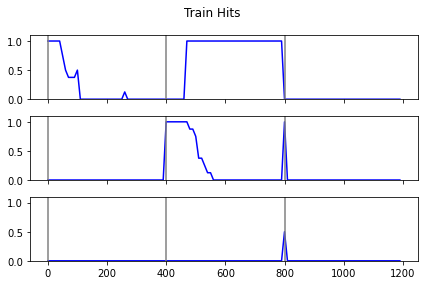

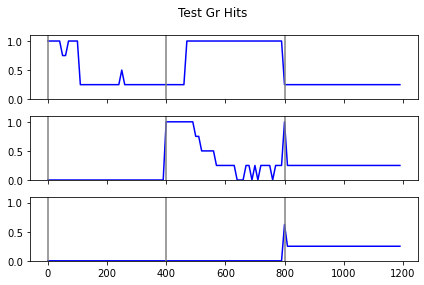

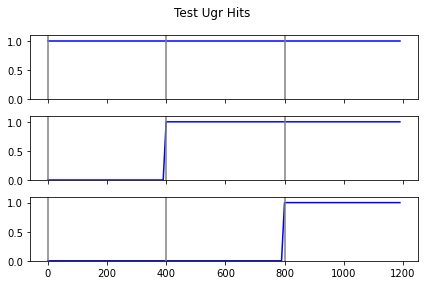

In [78]:
hist_loss_E = torch.cat(hist_losses_E, dim=2)
hist_hits_E = torch.cat(hist_hitsss_E, dim=2)

plotResults(hist_loss_E, hist_hits_E)

In [79]:
accuracyAll(models_E)


Model 0
Task 0: Acc 0.88% | Gr acc 0.75 | Ugr acc 1.0
Task 1: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 2: Acc 0.69% | Gr acc 0.38 | Ugr acc 1.0

Model 1
Task 0: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 1: Acc 0.88% | Gr acc 0.75 | Ugr acc 1.0
Task 2: Acc 0.69% | Gr acc 0.38 | Ugr acc 1.0

Model 2
Task 0: Acc 0.88% | Gr acc 0.75 | Ugr acc 1.0
Task 1: Acc 0.88% | Gr acc 0.75 | Ugr acc 1.0
Task 2: Acc 0.88% | Gr acc 0.75 | Ugr acc 1.0


In [209]:
models_E[2].n_active_experts

2

### bugfix

In [138]:
gating_trgts = []
gating_trgts.append( [torch.tensor([1,0,0]) for _ in range(len(train_dls[0]))])
gating_trgts.append( [torch.tensor([0,1,0]) for _ in range(len(train_dls[1]))])

In [144]:
for x,y in train_dls[1]:
    if x[1] == 7:
        print("hi")

In [163]:
gating, gating_optimizer = init_gating()
gating_criterion = nn.CrossEntropyLoss(ignore_index=-1)

In [168]:
gating, gating_optimizer = init_gating()
gating_criterion = nn.CrossEntropyLoss(ignore_index=-1)
for i in range(100):
    for seqs, seqs_len in train_dls[2]:

        gating.train()

        gating_optimizer.zero_grad()

        outputs = gating(seqs, seqs_len)

        #print("seq")
        #print(seqs)
        #print("outputs")
        #print(outputs)

        if seqs[1] == 7:
            trgts = torch.tensor([0])
        else:
            trgts = torch.tensor([1])

        loss = compute_loss(outputs, trgts, gating_criterion,
                            cutFirstInSequence=False)

        loss.backward()

        gating_optimizer.step()

        print("loss")
        print(loss.item())

loss
1.0986123085021973
loss
1.0986123085021973
loss
1.0986123085021973
loss
1.0986123085021973
loss
1.0990233421325684
loss
1.0725314617156982
loss
1.0986123085021973
loss
1.0986123085021973
loss
1.0986123085021973
loss
1.06223726272583
loss
1.1580368280410767
loss
0.994653046131134
loss
1.0136317014694214
loss
1.1363170146942139
loss
1.0377978086471558
loss
1.273862361907959
loss
1.1935420036315918
loss
1.2392826080322266
loss
0.843536376953125
loss
1.0642420053482056
loss
0.8814082145690918
loss
1.1417649984359741
loss
1.2824432849884033
loss
0.8938198089599609
loss
0.9051280617713928
loss
0.9723299145698547
loss
1.2795649766921997
loss
1.1691962480545044
loss
1.2110319137573242
loss
0.7188755869865417
loss
1.3590319156646729
loss
0.9704457521438599
loss
0.9680742025375366
loss
1.385023593902588
loss
0.7331454157829285
loss
0.7141051888465881
loss
1.245851993560791
loss
0.7735995054244995
loss
1.3736876249313354
loss
0.8231424689292908
loss
1.3750696182250977
loss
1.51996910572052
l

### bugfix

In [44]:
gating_criterion = nn.CrossEntropyLoss(ignore_index=-1)
expert_criterion = CosineLoss(OUTPUT_DIM, ignore_index=PAD_TOKEN)
expert_criterion_unreduced = CosineLoss(OUTPUT_DIM, ignore_index=PAD_TOKEN,
                                        reduction="none")


In [45]:
expert, expert_optimizer = init_expert()
gating, gating_optimizer = init_gating()
model = DynaMoE(gating, gating_optimizer, [expert,], [expert_optimizer,])
print(model.apply(init_weights))

DynaMoE(
  (gating): Gating(
    (embedding): Embedding(8, 10)
    (rnn): GRU(10, 10, bidirectional=True)
    (fc_out): Linear(in_features=20, out_features=3, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (experts): ModuleList(
    (0): Seq2Seq(
      (encoder): Encoder(
        (embedding): Embedding(8, 30)
        (rnn): GRU(30, 10, bidirectional=True)
        (fc): Linear(in_features=20, out_features=10, bias=True)
        (dropout): Dropout(p=0.7, inplace=False)
      )
      (decoder): Decoder(
        (attention): Attention(
          (attn): Linear(in_features=30, out_features=10, bias=True)
          (v): Linear(in_features=10, out_features=1, bias=False)
        )
        (embedding): Embedding(8, 30)
        (rnn): GRU(50, 10)
        (fc_out): Linear(in_features=60, out_features=8, bias=True)
        (dropout): Dropout(p=0.7, inplace=False)
      )
    )
  )
)


In [108]:
model.add_expert()

In [131]:
show_expert(model, train_dls[1])

1 - tensor([1, 5, 4, 7, 4, 6, 2])
1 - tensor([1, 5, 3, 4, 7, 2])
1 - tensor([1, 5, 4, 6, 7, 4, 6, 2])
1 - tensor([1, 5, 4, 7, 2])
1 - tensor([1, 5, 3, 4, 7, 4, 2])
1 - tensor([1, 5, 3, 4, 6, 7, 4, 6, 2])
1 - tensor([1, 5, 3, 4, 7, 4, 6, 2])
1 - tensor([1, 5, 4, 6, 7, 2])


In [132]:
show_expert(model, train_dls[0])

1 - tensor([1, 7, 4, 6, 5, 2])
1 - tensor([1, 7, 3, 4, 5, 4, 2])
1 - tensor([1, 7, 3, 4, 6, 5, 4, 6, 2])
1 - tensor([1, 7, 3, 4, 5, 2])
1 - tensor([1, 7, 3, 4, 5, 4, 6, 2])
1 - tensor([1, 7, 4, 6, 5, 4, 6, 2])
1 - tensor([1, 7, 4, 5, 4, 6, 2])
1 - tensor([1, 7, 4, 5, 2])


In [115]:
gating_optimizer = optim.Adam(model.gating.parameters(), lr=0.01)

In [133]:
for name, param in model.gating.named_parameters():
    if param.requires_grad:
        print(name)
        print(param.grad)

embedding.weight
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.3362e-14,
          0.0000e+00,  0.0000e+00, -1.0627e-14,  1.2231e-14,  0.0000e+00],
        [ 9.5526e-09,  0.0000e+00,  0.0000e+00,  0.0000e+00,  4.5729e-09,
         -8.0322e-09,  0.0000e+00, -1.3070e-08,  2.0716e-08,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -1.2082e-14, -4.8358e-12,  6.6748e-12, -6.2617e-12,
         -5.3810e-12,  7.6332e-12, -2.3784e-12,  0.0000e+00, -7.3044e-12],
        [-4.1353e-13, -4.9267e-13, -3.5623e-13,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  5.5728e-13,  0.0000e+00,  4.3358e-13, -5.3819e-13],
        [ 0.0000e+00,  0.0000e+00, -8.9321e-11,  5.7395e-14,  0.0000e+00,
         -1.001

In [ ]:
gating_criterion = nn.CrossEntropyLoss(ignore_index=-1)

In [ ]:
gating_criterion(torch.tensor([[0, 1.0000e+10, 0],
        [0, 1.0000e+10, 0]]),
        torch.tensor([1, 1]))

tensor(0.)

In [177]:
for x in range(100):
    print( train_dynamoe_gating(model, train_dls[1], gating_criterion,
                                expert_criterion_unreduced,
                                CLIP, verbose=True) )

Target
tensor([0])
Output
tensor([2])
>> Gating Loss
tensor(1.0986, grad_fn=<NllLossBackward>)
-- Masked Gating
tensor([[-2.3803e-05]], grad_fn=<SliceBackward>)
Target
tensor([0])
Output
tensor([0])
>> Gating Loss
tensor(1.0837, grad_fn=<NllLossBackward>)
-- Masked Gating
tensor([[0.0112]], grad_fn=<SliceBackward>)
Target
tensor([0])
Output
tensor([0])
>> Gating Loss
tensor(1.0650, grad_fn=<NllLossBackward>)
-- Masked Gating
tensor([[0.0255]], grad_fn=<SliceBackward>)
Target
tensor([0])
Output
tensor([0])
>> Gating Loss
tensor(1.0419, grad_fn=<NllLossBackward>)
-- Masked Gating
tensor([[0.0432]], grad_fn=<SliceBackward>)
Target
tensor([0])
Output
tensor([0])
>> Gating Loss
tensor(1.0131, grad_fn=<NllLossBackward>)
-- Masked Gating
tensor([[0.0657]], grad_fn=<SliceBackward>)
Target
tensor([0])
Output
tensor([0])
>> Gating Loss
tensor(0.9796, grad_fn=<NllLossBackward>)
-- Masked Gating
tensor([[0.0922]], grad_fn=<SliceBackward>)
Target
tensor([0])
Output
tensor([0])
>> Gating Loss
tensor

In [46]:
for x in range(400):
    print( train_dynamoe_both(model, train_dls[1], gating_criterion, expert_criterion_unreduced, CLIP) )

0.630012683570385
0.47744666039943695
0.44646283984184265
0.4113902524113655
0.4127246364951134
0.37290962785482407
0.43906231224536896
0.385328508913517
0.37053677439689636
0.3609902262687683
0.3726344630122185
0.3744181916117668
0.36561162024736404
0.3524796664714813
0.39585812389850616
0.32904189825057983
0.3342840299010277
0.3753737062215805
0.40356797724962234
0.3463684171438217
0.35821671038866043
0.36753934621810913
0.31112828850746155
0.3395487293601036
0.32247451692819595
0.31689079105854034
0.3214147612452507
0.3431061953306198
0.32723822444677353
0.3066282793879509
0.2927127256989479
0.3012479245662689
0.2619609013199806


KeyboardInterrupt: 

## Transfer F: DynaMoE with weighting instead of choosing

### DynaMoE2

In [157]:
class DynaMoE2(nn.Module):
    def __init__(self, gating, gating_optimizer, experts, expert_optimizers):
        """
        Parameters
        ----------
        gating: nn.Module
            Gating module
        gating_optimizer: optim
            optimizer for passed Gating module
        expert: list of nn.Module
            list of task experts
        expert_optimizers: list of optim
            list of optimizer for the expert at the same index
        """
        super(DynaMoE2, self).__init__()

        assert len(experts) == len(expert_optimizers)
        
        self.gating = gating
        self.gating_optimizer = gating_optimizer
        self.experts = nn.ModuleList(experts)
        self.expert_optimizers = expert_optimizers
        self.n_active_experts = 1

    def forward(self, seqs, seqs_len, trgs, teacher_forcing_ratio = 0.5):
        #seqs = [seqs len, batch size]
        #seqs_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing

        vocab_size = self.gating.input_dim
        seq_len, batch_size = seqs.shape
        
        # Decide which expert to use
        gatings = self.gating(seqs, seqs_len)

        # gatings = [batch_size, n_max_experts]
        
        gating_masked = gatings[:,:self.n_active_experts]

        expert_outputs = torch.empty((self.n_active_experts, seq_len, batch_size, vocab_size))
        for e_id in range(self.n_active_experts):
            expert_output = self.experts[e_id](seqs, seqs_len, seqs, teacher_forcing_ratio)
            # expert_output = [seqs_len, batch_size, vocab_size]

            # Weigh every experts output with respective gating weight
            for b in range(batch_size):
                #     expert_output[:,b] = expert_output[:,b] * gating_masked[b,e_id]
                #expert_outputs[e_id,:,b] = expert_output[:,b] * gating_masked[b,e_id]
                expert_outputs[e_id,:,b] = expert_output[:,b]
            
            # print("expert_out")
            # print(expert_output)
            # print("gating_masked")
            # print(gating_masked)

        weighted_outputs = expert_outputs.sum(dim=0)
        # weighted_outputs = [seqs_len, batch_size, vocab_size]

        return weighted_outputs

    def add_expert(self):
        # Get new expert
        expert, expert_optimizer = init_expert()
        self.experts.append(expert)
        self.expert_optimizers.append(expert_optimizer)
        self.n_active_experts += 1

### train_dynamoe2_gating

In [167]:
def train_dynamoe2_gating(model, iterator, criterion, clip, verbose=False):
    assert isinstance(model, DynaMoE2)
    model.gating.train()
    
    epoch_loss = 0
    
    for seqs, seqs_len in iterator:
        
        #seqs = [seq len, batch size]
        #output = [seq len, batch size, vocab sizen]
        vocab_size = model.gating.input_dim
        seq_len, batch_size = seqs.shape

        model.gating_optimizer.zero_grad()
        
        gating_outputs = model.gating(seqs, seqs_len)

        # gating_outputs = [batch_size, n_max_experts]
        
        gating_masked = gating_outputs[:,:model.n_active_experts]

        ## Compute best choice for gating network
        # Compute loss for each expert network
        expert_outputs = torch.empty((model.n_active_experts, seq_len,
                                      batch_size, vocab_size))
        for e_id in range(model.n_active_experts):

            model.experts[e_id].eval()

            expert_output = model.experts[e_id](seqs, seqs_len, seqs)
            # expert_output = [seqs_len, batch_size, vocab_size]



            # Weigh every experts output with respective gating weight
            for b in range(batch_size):
                #     expert_output[:,b] = expert_output[:,b] * gating_masked[b,e_id]
                expert_outputs[e_id,:,b] = expert_output[:,b] * gating_masked[b,e_id]
            
        weighted_outputs = expert_outputs.sum(dim=0)
        # weighted_outputs = [seqs_len, batch_size, vocab_size]

        # Gating Loss just is total loss
        gating_loss = compute_loss(weighted_outputs, seqs, expert_criterion,
                            cutFirstInSequence=True)
        
        if verbose:
            print(">> Gating Loss")
            print(gating_loss)

        gating_loss.backward()
        
        #torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        model.gating_optimizer.step()

        if verbose:
            print("-- Masked Gating")
            print(gating_masked)
        
        epoch_loss += gating_loss.item()
        
    return epoch_loss / len(iterator)

### train_dynamoe2_both

In [172]:
def train_dynamoe2_both(model, iterator, criterion, clip):
    assert isinstance(model, DynaMoE2)
    
    model.eval()
    model.experts[model.n_active_experts - 1].train()
    
    epoch_loss = 0
    
    for seqs, seqs_len in iterator:
        
        # model.gating_optimizer.zero_grad()
        model.expert_optimizers[model.n_active_experts - 1].zero_grad()
        
        outputs = model(seqs, seqs_len, seqs)
        
        loss = compute_loss(outputs, seqs, criterion, cutFirstInSequence=True)
        
        loss.backward()
        
        # model.gating_optimizer.step()
        model.expert_optimizers[model.n_active_experts - 1].step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

### fit_dynamoe2

In [135]:
def fit_dynamoe2(model, task_id, epochs, step_size_evaluation, clip,
                case = "train_gating_initialized_expert" ):
    """
    Parameters
    ----------
    case : string
        "train_gating_uninitialized_expert" | "train_gating_train_expert" | 
        "train_gating_initialized_expert"
    """
    best_valid_loss = float('inf')

    total_hits = torch.zeros((N_TASKS + 1, 3, epochs//step_size_evaluation,))
    total_loss = torch.zeros((N_TASKS + 1, 3, epochs//step_size_evaluation,))
    # [:,0,:] = train, [:,1,:] = test, [:,2,:] = test_ugr
    # [task_id, dataset, evaluations]

    loss_tracker = torch.zeros((epochs,))

    allowed_until_check = N_EPOCHS_UNTIL_NEW_EXPERT

    for epoch in range(epochs):

        if case == "train_gating_initialized_expert":
            start_time = time.time()
            
            train_loss = train_dynamoe2_gating(model, train_dls[task_id],
                                               criterion, clip)
            valid_loss = evaluate(model, valid_dls[task_id], criterion)
            
            end_time = time.time()

            # Log hits
            loss_tracker[epoch] = evaluate_extra(model, train_dls[task_id], allOrNoneLoss)

            # Check for improvement in loss
            if epoch > allowed_until_check:
                if (((loss_tracker[epoch - N_EPOCHS_UNTIL_NEW_EXPERT] - 
                         loss_tracker[epoch]) < ALLOWED_ERROR_VARIANCE)
                    and 
                    (valid_loss > PERFORMANCE_TRESHHOLD)
                ):
                    # Case of no improvement:
                    # Switch to train the expert and gating

                    case = "train_gating_train_expert"
                    allowed_until_check = epoch + N_EPOCHS_UNTIL_NEW_EXPERT
                    print("-----------------------------------")
                    print("------Switch to training both------")
                    print("-----------------------------------")

            
        if case == "train_gating_train_expert":
            start_time = time.time()
            
            train_loss = train_dynamoe2_both(model, train_dls[task_id],
                                               criterion, clip)
            valid_loss = evaluate(model, valid_dls[task_id], criterion)
            
            end_time = time.time()

        if case == "train_gating_uninitialized_expert":
            assert len(model.experts) > 0, "Need at least one expert"
            start_time = time.time()
            
            train_loss = train_dynamoe2_gating(model, train_dls[task_id],
                                               criterion, clip)
            valid_loss = evaluate(model, valid_dls[task_id], criterion)
            
            end_time = time.time()

            # Log loss
            loss_tracker[epoch] = valid_loss

            # Check for improvement in loss
            if epoch > N_EPOCHS_UNTIL_NEW_EXPERT:
                if (((loss_tracker[epoch - N_EPOCHS_UNTIL_NEW_EXPERT] - 
                         loss_tracker[epoch]) < ALLOWED_ERROR_VARIANCE)
                    and 
                    (valid_loss > PERFORMANCE_TRESHHOLD)
                   ):
                    # Case of no improvement:
                    # Initiate new expert and train gating and new expert on it
                    model.add_expert()

                    case = "train_gating_initialized_expert"
                    allowed_until_check = epoch + N_EPOCHS_UNTIL_NEW_EXPERT
                    print("-----------------------------------")
                    print("-----Added Expert-train Gating-----")
                    print("-----------------------------------")

            
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), SAVENAME)

        if epoch % STEP_SIZE_EVALUATION == 0:
            idx = epoch//STEP_SIZE_EVALUATION
            for other_id in range(task_id + 1):
                total_loss[other_id,0,idx] = evaluate(model, train_dls[other_id], expert_criterion)
                total_loss[other_id,1,idx] = evaluate(model, test_dls[other_id], expert_criterion)
                total_loss[other_id,2,idx] = evaluate(model, test_ugr_dls[other_id], expert_criterion)
                total_hits[other_id,0,idx] = evaluate_extra(model, train_dls[other_id], allOrNoneLoss)
                total_hits[other_id,1,idx] = evaluate_extra(model, test_dls[other_id], allOrNoneLoss)
                total_hits[other_id,2,idx] = evaluate_extra(model, test_ugr_dls[other_id], allOrNoneLoss)

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
    return total_loss, total_hits

### Experiment DynaMoE2

In [136]:
SAVE = N_EPOCHS

In [197]:
N_EXPERTS_START = 1
N_MAX_EXPERTS = 3
GATE_DROPOUT = 0.5
N_GATING_HIDDEN_DIM = 10
N_GATING_EMBED_DIM = 10
N_EPOCHS = SAVE + 200

# If the amount of missed hits is bigger then PERFORMANCE_TRESHHOLD
# and it stays within ALLOWED_ERROR_VARIANCE for
# N_EPOCHS_UNTIL_NEW_EXPERT epochs, then a new
# expert is initialized
N_EPOCHS_UNTIL_NEW_EXPERT = 30
ALLOWED_ERROR_VARIANCE = 0.1
PERFORMANCE_TRESHHOLD = 0.3

In [198]:
SEED = 54321
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [199]:
models_F = []
hist_losses_F = []
hist_hitsss_F = []

expert, expert_optimizer = init_expert()
gating, gating_optimizer = init_gating()
model = DynaMoE2(gating, gating_optimizer, [expert,], [expert_optimizer,])

# model_optimizer = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

print(model.apply(init_weights))

expert_criterion = CosineLoss(OUTPUT_DIM, ignore_index=PAD_TOKEN)

for n_task in range(N_TASKS + TEST_ALL_TASKS):
    SUFFIX = f"F{n_task}"
    title = f"{PREFIX}-AE-{ENC_EMB_DIM}-{ENC_HID_DIM}-{LEARNING_RATE}-{SUFFIX}"
    LOADNAME = MODELAUTOSAVE + title + ".pt"
    SAVENAME = MODELAUTOSAVE + title + ".pt"
    PLOTSAVE = PLOTSAUTOSAVE + title + ".png"
    print(title)
    print(f'The model has {count_parameters(model)} trainable parameters')
    
    if n_task == 0:
        case = "train_gating_initialized_expert"
    else:
        case = "train_gating_uninitialized_expert"
    hist_loss_temp, hist_hits_temp = fit_dynamoe2(model, n_task, N_EPOCHS,
                                                 STEP_SIZE_EVALUATION, CLIP,
                                                 case)
    hist_losses_F.append(hist_loss_temp)
    hist_hitsss_F.append(hist_hits_temp)
    models_F.append(copy.deepcopy(model))

DynaMoE2(
  (gating): Gating(
    (embedding): Embedding(8, 10)
    (rnn): GRU(10, 10, bidirectional=True)
    (fc_out): Linear(in_features=20, out_features=3, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (experts): ModuleList(
    (0): Seq2Seq(
      (encoder): Encoder(
        (embedding): Embedding(8, 30)
        (rnn): GRU(30, 10, bidirectional=True)
        (fc): Linear(in_features=20, out_features=10, bias=True)
        (dropout): Dropout(p=0.7, inplace=False)
      )
      (decoder): Decoder(
        (attention): Attention(
          (attn): Linear(in_features=30, out_features=10, bias=True)
          (v): Linear(in_features=10, out_features=1, bias=False)
        )
        (embedding): Embedding(8, 30)
        (rnn): GRU(50, 10)
        (fc_out): Linear(in_features=60, out_features=8, bias=True)
        (dropout): Dropout(p=0.7, inplace=False)
      )
    )
  )
)
tr-AE-30-10-0.01-F0
The model has 7341 trainable parameters
Epoch: 01 | Time: 0m 0s
	Train Loss: 0.

In [77]:
hist_loss_F = torch.cat(hist_losses_F, dim=2)
hist_hits_F = torch.cat(hist_hitsss_F, dim=2)

plotResults(hist_loss_F, hist_hits_F)

NameError: name 'hist_losses_F' is not defined

In [202]:
model.n_active_experts

2

In [201]:
accuracyAll(models_F)


Model 0
Task 0: Acc 0.88% | Gr acc 0.75 | Ugr acc 1.0
Task 1: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 2: Acc 0.69% | Gr acc 0.38 | Ugr acc 1.0

Model 1
Task 0: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 1: Acc 0.75% | Gr acc 0.5 | Ugr acc 1.0
Task 2: Acc 0.62% | Gr acc 0.25 | Ugr acc 1.0

Model 2
Task 0: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 1: Acc 0.75% | Gr acc 0.5 | Ugr acc 1.0
Task 2: Acc 0.62% | Gr acc 0.25 | Ugr acc 1.0


### show_expert2

In [207]:
def show_expert2(model, iterator):
    model.gating.eval()
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            seqs, seqs_len = batch

            batch_size = seqs.shape[1]

            gating_outputs = model.gating(seqs, seqs_len)

            gating_masked = gating_outputs[:,:model.n_active_experts]

            for b in range(batch_size):
                print(f"{gating_masked[b]} - {seqs[:,b]}")            

### bugfix

In [206]:
for seqs, seqs_len in train_dls[2]:
    print(model.gating(seqs, seqs_len))
    break

tensor([[ 1.2000e+01,  1.7990e-01, -1.0471e-02],
        [ 6.7971e+00,  6.8288e+00, -2.9813e-02]], grad_fn=<AddmmBackward>)


In [210]:
show_expert2(model, train_dls[2])

tensor([6.7971, 6.8288]) - tensor([1, 6, 7, 5, 3, 4, 5, 3, 2])
tensor([0.6660, 0.3219]) - tensor([1, 6, 7, 5, 4, 2, 0, 0, 0])
tensor([12.0075,  0.1695]) - tensor([1, 6, 5, 7, 4, 7, 3, 2])
tensor([0.6660, 0.3219]) - tensor([1, 6, 5, 7, 4, 7, 2, 0])
tensor([6.7159, 6.7874]) - tensor([1, 6, 5, 3, 4, 5, 3, 2])
tensor([0.6660, 0.3219]) - tensor([1, 6, 5, 4, 2, 0, 0, 0])
tensor([10.8500,  0.2858]) - tensor([1, 6, 7, 3, 4, 2])
tensor([0.6660, 0.3219]) - tensor([1, 6, 7, 4, 2, 0])
tensor([6.7845, 6.8455]) - tensor([1, 6, 7, 5, 4, 5, 3, 2])
tensor([0.6660, 0.3219]) - tensor([1, 6, 5, 4, 5, 3, 2, 0])
tensor([11.9999,  0.1799]) - tensor([1, 6, 5, 7, 3, 4, 7, 3, 2])
tensor([0.6660, 0.3219]) - tensor([1, 6, 7, 3, 4, 7, 3, 2, 0])
tensor([11.0634,  0.2913]) - tensor([1, 6, 7, 4, 7, 3, 2])
tensor([0.6660, 0.3219]) - tensor([1, 6, 5, 3, 4, 2, 0])
tensor([6.7663, 6.9836]) - tensor([1, 6, 7, 5, 4, 5, 2])
tensor([0.6660, 0.3219]) - tensor([1, 6, 5, 7, 4, 2, 0])


### bugfix

In [173]:
expert, expert_optimizer = init_expert()

gating, gating_optimizer = init_gating()

model2 = DynaMoE2(gating, gating_optimizer, [expert,], [expert_optimizer,])

model_optimizer = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

In [174]:
criterion = CosineLoss(OUTPUT_DIM, ignore_index=PAD_TOKEN)

In [194]:
for _ in range(100):
    print(train_dynamoe2_gating(model2, train_dls[2], criterion, CLIP))

0.22869906201958656
0.19848032295703888
0.17827840894460678
0.1478596329689026
0.1328919641673565
0.11753029003739357
0.13586381450295448
0.12771780043840408
0.12642693519592285
0.10890525579452515
0.11053463444113731
0.11512905731797218
0.10789792984724045
0.1396242491900921
0.13007165119051933
0.10671130195260048
0.12281512469053268
0.11282141506671906
0.11576562002301216
0.11426208913326263
0.09666670113801956
0.10877194255590439
0.11849036067724228
0.10577232390642166
0.11337213218212128
0.11631719395518303
0.10239308699965477
0.11547045782208443
0.09947025775909424
0.11925547197461128
0.1172763966023922
0.09785504266619682
0.11256325617432594
0.11795744299888611
0.12875186279416084
0.11906967684626579
0.11535120382905006
0.12183238565921783
0.11042068153619766
0.1258276328444481
0.10611820220947266
0.11356543004512787
0.12004068866372108
0.11736428737640381
0.10979463905096054
0.1302037090063095
0.10663412138819695
0.12038356065750122
0.10787971690297127
0.10383082553744316
0.1187

In [196]:
for seqs, seqs_len in train_dls[1]:
    print(model2.gating(seqs, seqs_len))
    break

tensor([[4.4835, 6.2265, 0.7313],
        [0.6559, 0.2670, 0.2011]], grad_fn=<AddmmBackward>)


In [186]:
for seqs, seqs_len in train_dls[1]:
    print(model2.experts[1](seqs, seqs_len, seqs).argmax(dim=2))
    print(seqs)
    break

tensor([[0, 0],
        [6, 6],
        [7, 5],
        [5, 3],
        [4, 4],
        [5, 2]])
tensor([[1, 1],
        [6, 6],
        [7, 5],
        [5, 3],
        [4, 4],
        [2, 2]])


In [137]:
N_EPO

200

In [185]:
for _ in range(100):
    print(train_dynamoe2_both(model2, train_dls[1], criterion, CLIP))

0.16881714761257172
0.15141833573579788
0.15692844986915588
0.15707916021347046
0.15791257470846176
0.18426920473575592
0.15594960004091263
0.2099481225013733
0.19191593676805496
0.16780265420675278
0.16559413820505142
0.14507802575826645
0.14517706632614136
0.15876172482967377
0.18021392822265625
0.14854232966899872
0.17011234909296036
0.19770054519176483
0.15062608569860458
0.16328270733356476
0.1630496382713318
0.15208538621664047
0.1585157811641693
0.1476331725716591
0.19418861716985703
0.14303864538669586
0.15178367495536804
0.13727358728647232
0.14693152904510498
0.16229414194822311
0.16068880259990692
0.13847041130065918
0.17334415018558502
0.15148300677537918
0.16502273082733154
0.14539223909378052
0.12727899849414825
0.1345638856291771
0.14078588038682938
0.16145791113376617
0.1524231731891632
0.1419893577694893
0.12537699937820435
0.14602867513895035
0.14317089319229126
0.16259494423866272
0.17060024291276932
0.1443256139755249
0.13479702174663544
0.15025698393583298
0.142252

In [183]:
model2.add_expert()

In [102]:
for seqs, seqs_len in train_dls[0]:
    print(seqs)
    print(model2(seqs, seqs_len, seqs))
    break

tensor([[1],
        [5],
        [3],
        [6],
        [7],
        [4],
        [6],
        [7],
        [2]])
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 1.6035e-04, -3.0651e-03, -3.0967e+00,  5.0364e+00, -2.0193e+00,
           1.1399e+01, -1.7679e+00,  4.7675e+00]],

        [[-1.7267e-02, -1.7725e-02, -2.5892e+00,  8.6882e+00, -3.9250e-02,
           2.2423e+00,  2.9604e+00,  1.6000e+00]],

        [[-6.3461e-03, -2.2191e-02, -3.4556e+00,  2.0296e-01,  1.4208e-01,
          -6.5787e-02,  1.4856e+01,  2.9764e+00]],

        [[-1.5827e-02, -6.2566e-03, -2.2252e+00,  1.3526e+00,  6.0539e+00,
          -3.2105e-01,  1.5760e+00,  7.5781e+00]],

        [[-1.3362e-02,  1.7968e-02,  3.8569e+00, -1.9823e+00,  8.1386e+00,
           1.5963e+00, -1.1647e-02,  1.3524e+00]],

        [[-5.1290e-03, -1.0336e-02,  3.7318e+00,  1.4661e+00, -1.7547e+00,
          -1.2773e+00,  1.0091e+01,  2.9304e+

## Transfer G: DynaMoE with context vector

1. Give DynaMoE additional artificial context onehot vector encoding
2. Use Continual Learning technique to make gating network remember task
3. In this case, replay (maybe later EWC)

### GatingContext

In [ ]:
class Gating(nn.Module):
    def __init__(self, input_dim, embed_dim, n_gating_hidden, n_experts,
                 n_max_experts, dropout):
        super().__init__()

        self.input_dim = input_dim
        
        self.n_experts = n_experts

        self.n_max_experts = n_max_experts
        
        self.embedding = nn.Embedding(input_dim, embed_dim)
        
        self.rnn = nn.GRU(embed_dim, n_gating_hidden, bidirectional=True)

        self.fc_out = nn.Linear(n_gating_hidden * 2, n_max_experts)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, seqs, seqs_len, context):
        
        # seqs = [seq len, batch_size]
        # seqs_len = [batch_size]
        
        embedded = self.dropout(self.embedding(seqs))
        
        # embedded = [seq len, batch_size, embed_dim]

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, seqs_len.to("cpu"))

        packed_outputs, hidden = self.rnn(packed_embedded)

        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)

        # outputs = [seq len, batch_size, n_experts * num directions]
        # hidden = [n layers * num directions, batch size, n_experts]

        hidden = hidden.squeeze(0)

        # hidden = [batch_size, n_max_experts]

        outputs = outputs[-1]

        outputs = self.fc_out(outputs)

        # outputs = [batch_size, n_max_experts]

        return outputs
        return F.softmax(outputs, dim=1)

### DynaMoEContext

In [ ]:
class DynaMoEContext(nn.Module):
    def __init__(self, gating, gating_optimizer, experts, expert_optimizers):
        """
        Parameters
        ----------
        gating: nn.Module
            Gating module
        gating_optimizer: optim
            optimizer for passed Gating module
        expert: list of nn.Module
            list of task experts
        expert_optimizers: list of optim
            list of optimizer for the expert at the same index
        """
        super(DynaMoE, self).__init__()

        assert len(experts) == len(expert_optimizers)
        
        self.gating = gating
        self.gating_optimizer = gating_optimizer
        self.experts = nn.ModuleList(experts)
        self.expert_optimizers = expert_optimizers
        self.n_active_experts = 1
        # set mask
        self.recompute_mask()
    
    def recompute_mask(self):
        gating_mask = torch.zeros(self.gating.n_max_experts).to(device)

        for e_id in range(self.n_active_experts):
            gating_mask[e_id] = 1

        self.gating_mask = gating_mask

    def forward(self, seqs, seqs_len, trgs, teacher_forcing_ratio=0.5):
        #seqs = [seqs len, batch size]
        #seqs_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing

        vocab_size = self.gating.input_dim
        seq_len, batch_size = seqs.shape
        
        # Decide which expert to use
        gatings = self.gating(seqs, seqs_len)

        # gatings = [batch_size, n_max_experts]
        
        masked_gatings = gatings[:,:self.n_active_experts]
        
        # @TODO: Probabilistic vs argmax?
        network_ids = torch.argmax(masked_gatings, dim=1)

        expert_outputs = []
        for e_id in range(self.n_active_experts):
            expert_outputs.append(self.experts[e_id](seqs, seqs_len, seqs,
                                                     teacher_forcing_ratio))

        outputs = torch.empty((seq_len, batch_size, vocab_size))

        for b in range(batch_size):
            network_id = network_ids[b]
            outputs[:,b] = expert_outputs[network_id][:,b]
        
        return outputs

    def add_expert(self):
        # Get new expert
        expert, expert_optimizer = init_expert()
        self.experts.append(expert)
        self.expert_optimizers.append(expert_optimizer)
        self.n_active_experts += 1
        # Recompute mask
        self.recompute_mask()